# Crossmatch SDSS to all

Taking the 9258  S82 QSO from SDSS (DBQSO). Seek to find the PS1, PTF, CRTS, data. Mostly based on AA_crossmatch_to_all,  but doing the outer join, to have as much data as possible, especially that in the end we only use SDSS-PS1,... So relax the hitherto stringent condition imposed by inner join that the quasar has to have SDSS-PS1-PTF-CRTS data altogether ....  <a id='toc'></a>
    
   * cross-match, regardless of filter:
    * [SDSS-PS1](#sdss_ps1)
    * [SDSS-PTF](#sdss_ptf)
    * [SDSS-CRTS](#sdss_crts)
    * [SDSS-CRTS-PTF-PS1 : outer join](#join)
   * store per object [time, mag, magerr, filter, survey] in dp2/real_outer_join/
   * next step : combine all to SDSS-r master band 

In [22]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## SDSS-PS1

In [2]:
ps1_qso_schneider = os.listdir('../raw_data/schneider/')

# grab ra, dec from filenames 
ra_ps1 = np.array([coord[:9] for coord in ps1_qso_schneider])
dec_ps1 = np.array([coord[9:] for coord in ps1_qso_schneider])

# make into AstroPy - digestible format.. 
ra_ps1_split = [ra[:2] + ' '+ ra[2:4] + ' '+ra[4:] for ra in ra_ps1]
dec_ps1_split = [dec[:3]+ ' '+ dec[3:5]+ ' ' + dec[5:] for dec in dec_ps1]

# combining the two.. 
radec_ps1_split = np.zeros_like(ra_ps1_split, dtype='U32')
for i in range(len(ra_ps1_split)):
    radec_ps1_split[i] = ra_ps1_split[i] + ' ' + dec_ps1_split[i]

c = SkyCoord(radec_ps1_split, frame='icrs', unit=(u.hourangle, u.deg)) 

# Check how many SDSS S82 DR9 QSOs have PS1 matches 
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']

# 9258 QSO ....
SDSS_DB_QSO= Table.read(File, format='ascii', names = colnames)
sdss_catalog = SkyCoord(ra=SDSS_DB_QSO['ra']*u.degree, dec=SDSS_DB_QSO['dec']*u.degree)


# Match Schneider PS1 to SDSS S82 DR7 : 
# better : match SDSS to PS1,  
# because there is less 
idx, sep2d, dist3d = sdss_catalog.match_to_catalog_sky(c) 
SDSS_DB_QSO['d2d_arcsec']=sep2d.value*3600

ps1id = np.asarray(ps1_qso_schneider)[idx]
ps1ra = c[idx].ra.deg
ps1dec = c[idx].dec.deg
ps1 = Table([ps1id, ps1ra, ps1dec], names=['ps1id', 'ps1ra', 'ps1dec'])

sdss_ps1 = hstack([SDSS_DB_QSO, ps1])


In [3]:
matchRadiusArcsec = 0.5
fname = 'SDSS_DB9_PS1_QSO_database.txt'
mask = sdss_ps1['d2d_arcsec'] < matchRadiusArcsec
print('Of ', len(SDSS_DB_QSO) , ' SDSS DB9 QSO, ', 
      np.sum(mask), 
    ' has a PS1 match within ', matchRadiusArcsec, ' arcseconds ')

print('We save these to ', fname)
sdss_ps1[mask].write(fname, format='ascii', overwrite=True)

Of  9258  SDSS DB9 QSO,  9248  has a PS1 match within  0.5  arcseconds 
We save these to  SDSS_DB9_PS1_QSO_database.txt


In [3]:
sdss_ps1 = Table.read('SDSS_DB9_PS1_QSO_database.txt', format='ascii')

In [35]:
sdss_ps1[m][['dbID', 'ps1ra', 'ps1dec']]

dbID,ps1ra,ps1dec
int64,float64,float64
7001,3.6834166666666666,-0.005138888888888889
14323,1.8242499999999997,-0.8604722222222222
27945,1.4543749999999998,-0.5765277777777778
36251,0.07449999999999998,0.43683333333333335
45836,3.031125,0.4519722222222222
46915,0.24258333333333332,-0.7795833333333334
62620,1.175125,0.5058333333333334


In [42]:
dbID = [7001, 27945, 45836,46915, 62620, 14323, 36251]
m = np.in1d(sdss_ps1['dbID'],dbID)
#sdss_ps1[m][['dbID', 'ps1ra', 'ps1dec']].write('ps1_high_var.txt',
#                                              format='ascii', overwrite='True')

sdss_ps1.meta = {'comments': ['']}

selection =  sdss_ps1[m][['dbID', 'ps1ra', 'ps1dec']].copy()

In [44]:

selection.rename_column('dbID', 'target')
selection.rename_column('ps1ra', 'ra')
selection.rename_column('ps1dec', 'dec')
selection.write('ps1_high_var.csv' ,format='csv', comment='#', 
                                               overwrite='True')

* log to  http://mastweb.stsci.edu/ps1casjobs/SubmitJob.aspx  (suberlak , Xcd... just numbers....), 
* ingest this list  `ps1_high_var.txt` as  a database ,
* set context to `PanStarrs1`
* execute query searching for nearby  stars...  
"DR2 release also includes the detection catalog containing all the multi-epoch observations." 

- an overview of everything: https://outerspace.stsci.edu/display/PANSTARRS/How+to+retrieve+and+use+PS1+data 


- there is forced photometry  https://outerspace.stsci.edu/display/PANSTARRS/PS1+Forced+photometry+of+sources  
- as well as single epoch detections  https://outerspace.stsci.edu/display/PANSTARRS/PS1+Detection+properties
- can also use a high-level GUI  Catalog search https://catalogs.mast.stsci.edu/panstarrs/ 

- many useful sample queries here https://outerspace.stsci.edu/display/PANSTARRS/PS1+Sample+queries#PS1Samplequeries-Obtainlightcurvesforagivensetofobjects  - that's perfect, because it walks me step by step (literally!!!  )  

- since I need to obtain light curves for nearby stars, the queries above should work well ... 

==> first , get the objIDs for objects within 30 asec : this yields 13 rows for my 7 qso's 

    SELECT d.dbID, d.ps1ra, d.ps1dec,
    o.objID, 
    o.raMean, o.decMean, o.raMeanErr, o.decMeanErr,
    o.qualityFlag,
    o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanPSFMagNpt,
    o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanPSFMagNpt,
    o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanPSFMagNpt,
    o.zMeanPSFMag, o.zMeanPSFMagErr, o.zMeanPSFMagNpt,
    o.yMeanPSFMag, o.yMeanPSFMagErr, o.yMeanPSFMagNpt,
    o.rMeanKronMag, o.rMeanKronMagErr,
    o.nDetections, o.ng, o.nr, o.ni, o.nz,o.ny,
    o.gFlags, o.gQfPerfect,
    o.rFlags, o.rQfPerfect,
    o.iFlags, o.iQfPerfect,
    o.zFlags, o.zQfPerfect,
    o.yFlags, o.yQfPerfect,
    soa.primaryDetection, soa.bestDetection
     INTO mydb.[ps1_var_objids]
     FROM mydb.[ps1_var] d
    CROSS APPLY dbo.fGetNearbyObjEq(d.ps1ra, d.ps1dec, 30.0/60.0) as x
    JOIN MeanObjectView o on o.ObjID=x.ObjId
    LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
    WHERE o.nDetections>5
    AND soa.primaryDetection>0
    AND o.gQfPerfect>0.85 and o.rQfPerfect>0.85 and o.iQfPerfect>0.85 and o.zQfPerfect>0.85
    AND (o.rmeanpsfmag - o.rmeankronmag < 0.05) 



-- then, obtain the detections from the detections table for all objIDs 

    SELECT o.objID, o.raMean, o.decMean,
    d.ra, d.dec, d.raErr, d.decErr,
    d.detectID, d.obstime, d.exptime, d.airmass, d.psfflux, d.psffluxErr, d.psfQf, d.psfQfPerfect, d.psfLikelihood, d.psfChiSq, d.extNSigma, d.zp, d.apFlux, d.apFluxErr,
    d.imageID, d.filterID,
    d.sky, d.skyerr, d.infoflag, d.infoflag2, d.infoflag3,
    o.qualityFlag,
    o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanPSFMagNpt,
    o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanPSFMagNpt,
    o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanPSFMagNpt,
    o.zMeanPSFMag, o.zMeanPSFMagErr, o.zMeanPSFMagNpt,
    o.yMeanPSFMag, o.yMeanPSFMagErr, o.yMeanPSFMagNpt,
    o.rMeanKronMag, o.rMeanKronMagErr,
    o.nDetections, o.ng, o.nr, o.ni, o.nz,o.ny,
    o.gFlags, o.gQfPerfect,
    o.rFlags, o.rQfPerfect,
    o.iFlags, o.iQfPerfect,
    o.zFlags, o.zQfPerfect,
    o.yFlags, o.yQfPerfect,
    o.primaryDetection, o.bestDetection
     INTO mydb.[ps1_var_det]
     FROM mydb.[ps1_var_objids] o
    JOIN Detection d on d.ObjID = o.ObjID

Note:  initially the search radius was 30/60  -  30 asec , but then I increased  to 1 amin. Zeljko mentioned that increasing to 3 amin would basically increase the area 10 times so that I could expect  to find 10 times more comparison stars. I submitted that too.

The resulting tables are in **MyDB** :  

ps1_var : the list of quasars 

* 30 asec  : 
 * matching objects   `ps1_var_objids`   
 * all detections of these objects : `ps1_var_det`

* 1 amin : 
 * matching objects: `ps1_var_objids_1amin`
 * all detections  `ps1_var_det_1amin`
 
* 3 amin :
 * matching objects : `ps1_var_objids_3amin`
 * all detections `ps1_var_det_3amin`


**aside** In the meantime  manually searched    the quick-view catalog  for dbID=7001, querying the dr2 detections table within 10 asec.  I saved the results as `dbID-7001_ps1_dr2_detection_10_asec.txt`

In [45]:
db7001 = Table.read('dbID-7001_ps1_dr2_detection_30_asec.txt', format='ascii')

In [49]:
selection


target,ra,dec
int64,float64,float64
7001,3.6834166666666666,-0.005138888888888889
14323,1.8242499999999997,-0.8604722222222222
27945,1.4543749999999998,-0.5765277777777778
36251,0.07449999999999998,0.43683333333333335
45836,3.031125,0.4519722222222222
46915,0.24258333333333332,-0.7795833333333334
62620,1.175125,0.5058333333333334


84 107990036807252743
77 107990036811466998
78 107990036834104286


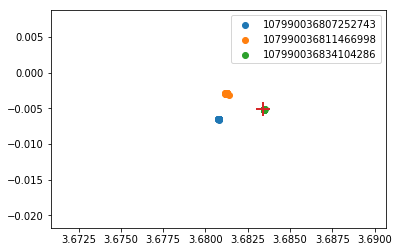

In [58]:
%matplotlib inline
for ID in np.unique(db7001['objID'].data):
    m = db7001['objID'] == ID 
    if np.sum(m) > 5 : 
        print(np.sum(m), ID)
        plt.scatter(db7001['ra'][m], db7001['dec'][m], label=ID)
ms = selection['target'] == 7001
plt.scatter(selection['ra'][ms], selection['dec'][ms], marker='+',s =200,lw=2,
           label='')
plt.legend()

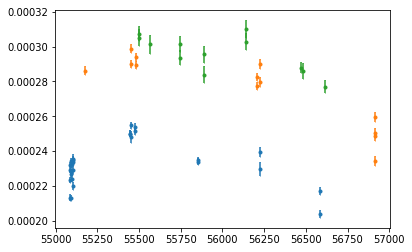

In [69]:

m_obj = db7001['objID'] == 107990036807252743
m_obj = db7001['objID'] == 107990036811466998
m_obj = db7001['objID'] == 107990036834104286
for f in [2,3,4]:
    m_filter  = db7001['filterID'] == f # select gri  

    m = m_filter & m_obj

    plt.errorbar(db7001['obsTime'][m], db7001['psfFlux'][m], 
                 db7001['psfFluxErr'][m], fmt=".", capsize=0.2, )

## ** results of the query ** 


In [4]:
# objids  within 30 asec of the 7 quasars 
ps1ids = Table.read('ps1_var_objids_suberlak.csv', format='csv')

#detections corresponding to these objids
ps1det = Table.read('ps1_var_det_suberlak.csv', format='csv')

In [5]:
d2d = np.sqrt((ps1ids['ps1ra']-ps1ids['raMean'])**2.0 + 
        (ps1ids['ps1dec']-ps1ids['decMean'])**2.0)
ps1ids['d2d'] = d2d

In [17]:
ps1ids[['dbID', 'objID', 'ps1ra', 'ps1dec', 'raMean', 'decMean', 'd2d']]

dbID,objID,ps1ra,ps1dec,raMean,decMean,d2d
int64,int64,float64,float64,float64,float64,float64
7001,107990036807252743,3.68341666666667,-0.00513888888888889,3.68077485,-0.00645839,0.002953011764710502
7001,107990036811466998,3.68341666666667,-0.00513888888888889,3.68123039,-0.00290119,0.003128434429640556
7001,107990036834104286,3.68341666666667,-0.00513888888888889,3.68347292,-0.00514911,5.717437033364135e-05
7001,107990036909210242,3.68341666666667,-0.00513888888888889,3.6910314,-0.00851577,0.008329915352289224
14323,106960018214400101,1.82425,-0.860472222222222,1.82144502,-0.86699363,0.007099061360804143
14323,106960018243237844,1.82425,-0.860472222222222,1.82427987,-0.86049785,3.935733595972055e-05
27945,107300014543848615,1.454375,-0.576527777777778,1.45439837,-0.57654439,2.8672684338203678e-05
27945,107310014571173592,1.454375,-0.576527777777778,1.45717666,-0.5723974,0.004990923696347478
36251,108520000745314660,0.0745,0.436833333333333,0.07453835,0.43683825,3.866388639434144e-05


Since all objects are within 30 asec I just assume cartesian plane, and calculate cartesian distance $d_{2D} = \sqrt{(\alpha_{1}-\alpha_{2})^2 + (\delta_{1}-\delta_{2})^2}$. Whichever object within 30 asec where $d_{2D} <  5 \cdot 10^{-4}$ (i.e. within 0.0005 degree = 1.8 asec ) is the light curve of the quasar - others are nearby stars (the galaxies should have been discarded by requiring `o.rmeanpsfmag - o.rmeankronmag < 0.05` in the first query ) :

In [7]:
ps1ids['quasar'] = 0
m = ps1ids['d2d'] < 5e-4
ps1ids['quasar'][m] = 1 

In [81]:
ps1ids[['dbID', 'objID', 'quasar']]

dbID,objID,quasar
int64,int64,int64
7001,107990036807252743,0
7001,107990036811466998,0
7001,107990036834104286,1
7001,107990036909210242,0
14323,106960018214400101,0
14323,106960018243237844,1
27945,107300014543848615,1
27945,107310014571173592,0
36251,108520000745314660,1


First p
lot quasar light curves to make sure they look like the ones I have from Chelsea...

In [ ]:
# I convert PSF fluxes to magnitudes using the zero point informatiopn : 
ps1det['psfflux', 'psffluxErr','zp']

In [8]:
np.unique(ps1det['filterID'].data) # grizy  ==  12345

array([1, 2, 3, 4, 5])

In [13]:
# https://outerspace.stsci.edu/display/PANSTARRS/PS1+Detection+table+fields
# note: psfflux and psffluxerr  are in Janskys  ,
# so use the AB magnitudes zero point of 8.9 
# 

ps1det['psfmag'] = -2.5* np.log10(ps1det['psfflux'])  +  8.9 # 
ps1det['psfmagErr'] = (5.0 / (2*np.log(10))) * (ps1det['psffluxErr'] / ps1det['psfflux'])    


# check the difference between the mean magnitudes from psfflux and 
# the mean magnitudes cited in the MeanTable view 
# they should be tiny ! 
m1 = ps1det['filterID'] == 1 # g    ( 12345 == grizy )
for objID in np.unique(ps1det['objID'].data):
    m2 = ps1det['objID'] == objID
    m = m1&m2
    #ps1det[['objID', 'obstime', 'psfmag', 'psfmagErr','zp', 
    #    'filterID', 'gMeanPSFMag']][m]
    
    # calculate the mean psfmag for that object of what I found .... 
    meanpsfmag = np.mean(ps1det['psfmag'][m])
    
    # find the difference between what the pipeline claims for that filter (g)
    # # supposedly these are AB magnitudes 
    diff = meanpsfmag  - ps1det['gMeanPSFMag'][m][0]  
    
    print(diff)

3.734012959455413e-05
0.2074766399921799
-0.02012742938937606
0.029219131839830936
-0.016865652268027276
-0.04339464671479121
0.023082759567021327
-0.06792207082840918
0.08284903718945102
0.020678531043255788
-0.0010325239867299274
-4.0134862871354926e-05
0.06826820222637053


And they are  - which means that I got the magnitude calculation right.... 

Very useful : this shows transmisson curves and different filter characteristics ... http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=PAN-STARRS/PS1.g&&mode=browse&gname=PAN-STARRS&gname2=PS1  and the data used to make the transmission curves for the PS1 filters http://ipp.ifa.hawaii.edu/ps1.filters/apj425122t3_mrt.txt 

The code below plots the detection data for quasars...

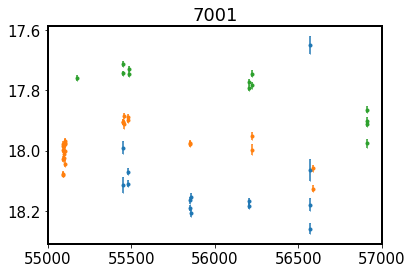

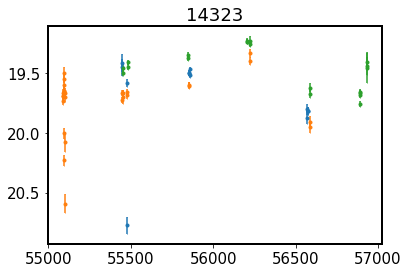

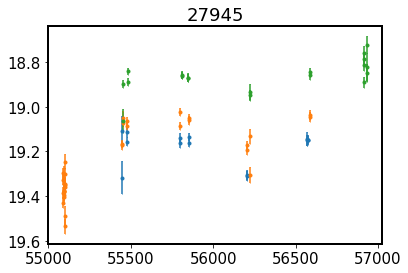

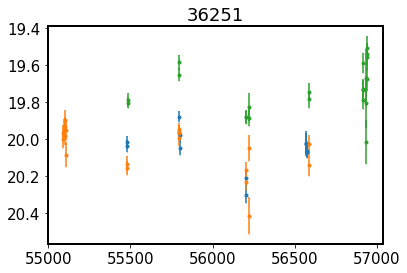

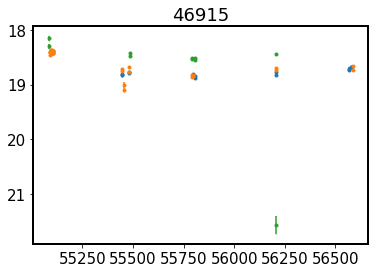

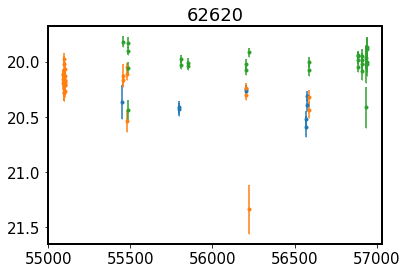

In [33]:
%matplotlib inline
for dbID in np.unique(ps1ids['dbID']):
    m_dbID = ps1ids['dbID'] == dbID
    m_qso = ps1ids['quasar'] == 1
    m = m_dbID & m_qso
    objID = ps1ids['objID'].data[m]
    
    fig,ax = plt.subplots(1,1)
    ax.set_title(dbID)
    m_objID = ps1det['objID'] == objID
    for filterid in [1,2,3]: # PS1 grizy == 12345 ==> gri == 123
        m_filter = ps1det['filterID'] == filterid
        
        m = m_objID & m_filter
        
        ax.errorbar(ps1det['obstime'][m],
                     ps1det['psfmag'][m],ps1det['psfmagErr'][m],  
                     fmt=".", capsize=0.2, )
        ax.invert_yaxis()

Plot quasar and nearby stars on the same plot , to make the comparisomn easier.... 



In [48]:
ps1det.remove_rows?

In [50]:

# objids  within 30 asec of the 7 quasars 
ps1ids = Table.read('ps1_var_objids_3amin_suberlak.csv', format='csv')

#detections corresponding to these objids
ps1det = Table.read('ps1_var_det_3amin_suberlak.csv', format='csv')

# find the 2d cartesian distance ... 
d2d = np.sqrt((ps1ids['ps1ra']-ps1ids['raMean'])**2.0 + 
        (ps1ids['ps1dec']-ps1ids['decMean'])**2.0)
ps1ids['d2d'] = d2d

# those objects that are super close to the quasar 
# are the quasar itself 

ps1ids['quasar'] = 0
m = ps1ids['d2d'] < 5e-4
ps1ids['quasar'][m] = 1 

#  drop all rows that have bad flux measurements
ps1det.remove_rows(ps1det['psfflux'] < 0 )

# calculate AB magnitudes from fluxes 
ps1det['psfmag'] = -2.5* np.log10(ps1det['psfflux'])  +  8.9 # 
ps1det['psfmagErr'] = (5.0 / (2*np.log(10))) * (ps1det['psffluxErr'] / ps1det['psfflux'])    




/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


IndexError: index 22 is out of bounds for axis 0 with size 22

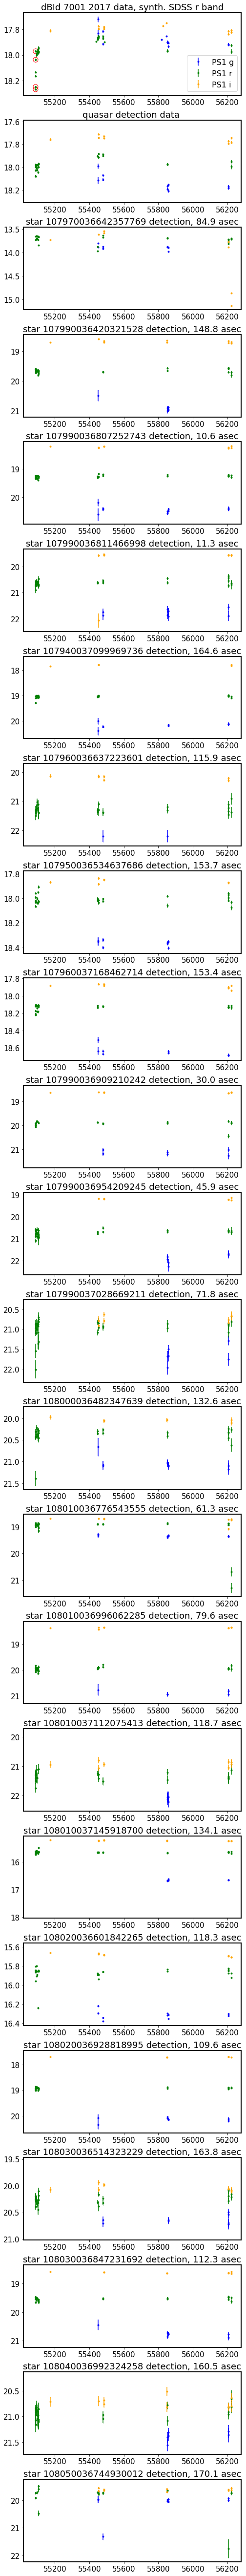

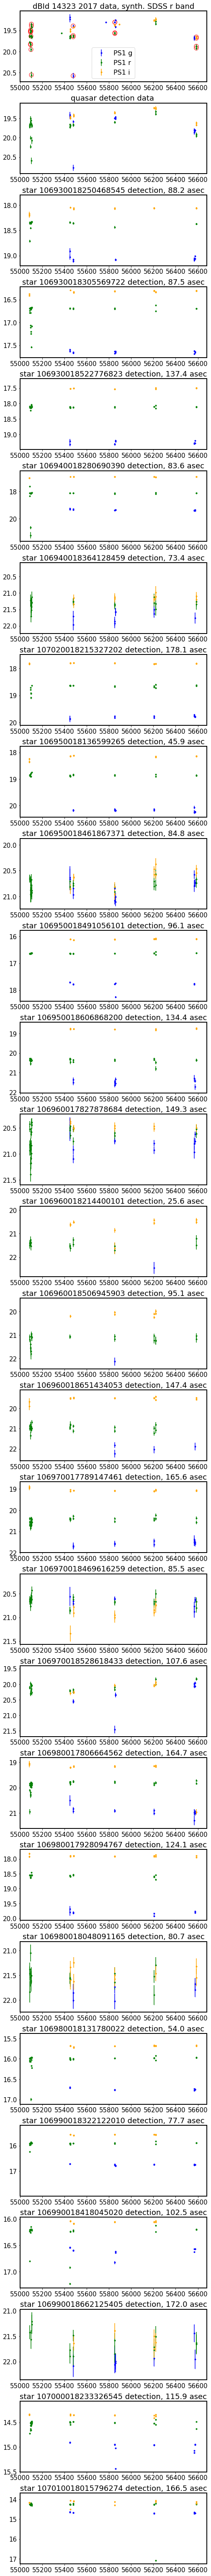

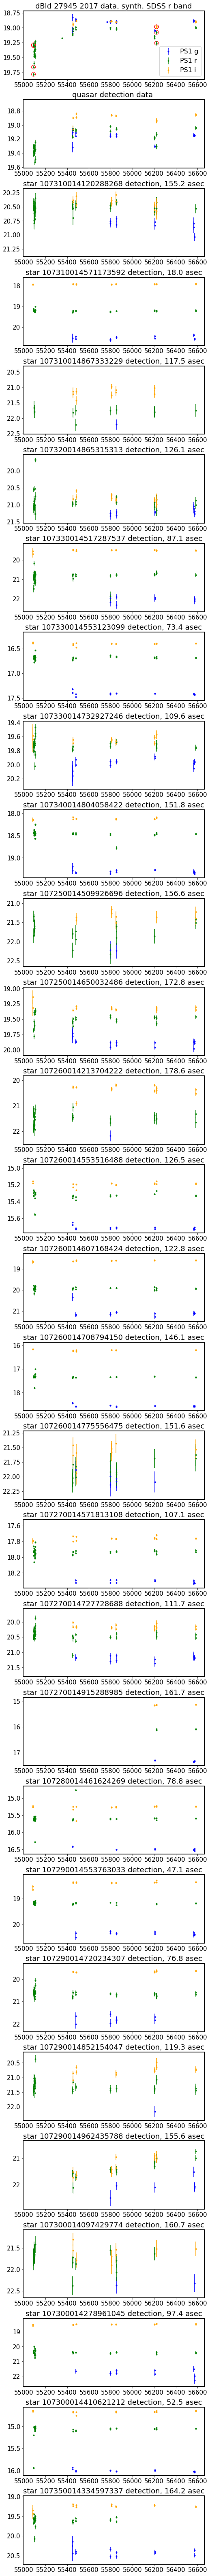

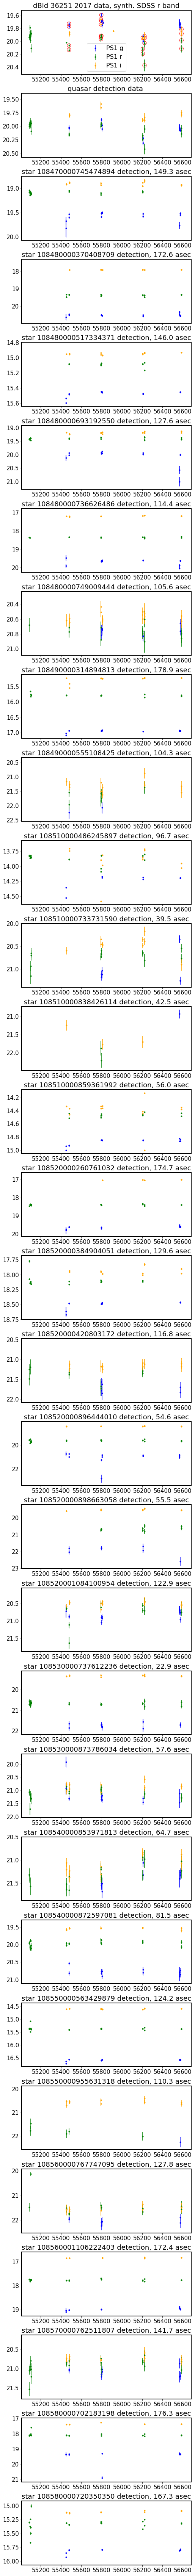

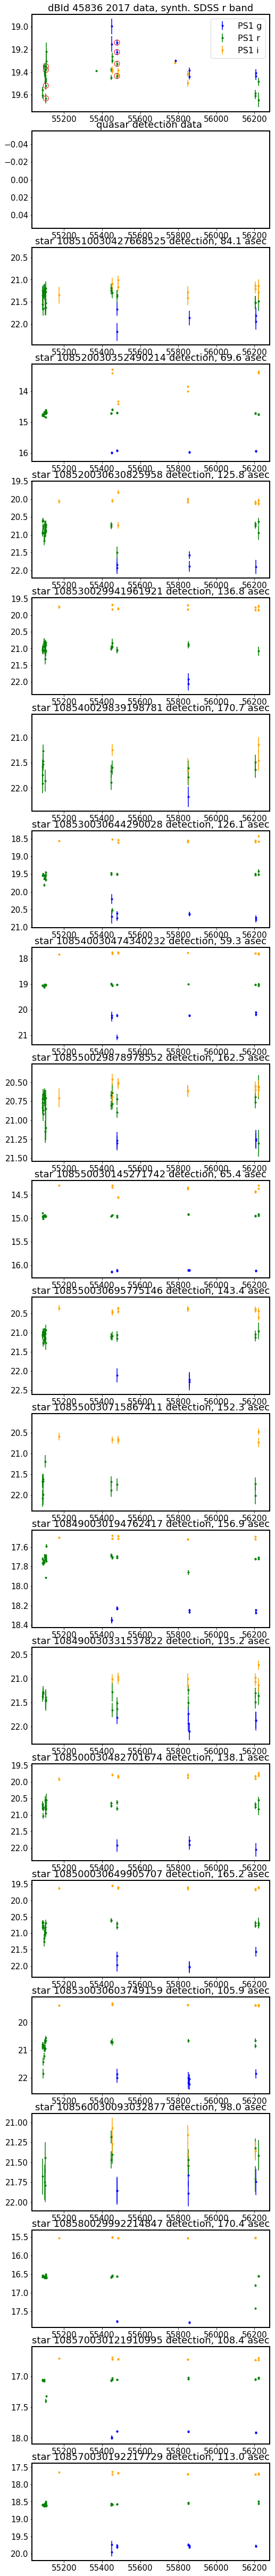

In [53]:
%matplotlib inline
#quasar light curves are here 
output_dir = '../dp2/real_combined_r_with_variances/'

dbIDs,counts,  = np.unique(ps1ids['dbID'],return_counts=True)
for dbID, count in zip(dbIDs,counts):
    lcname = str(dbID) + '.txt'

    lc_real =  Table.read(output_dir+lcname, format='ascii')

    m1 = lc_real['originSurvey'] == 'ps1'
    count = count+1 # add one because we'll plot at the top the 
    # quasar data from Chelsea brought to common filter 
    # then the quasar detection data, 
    # and finally the detection data for all stars  
    fig,axs = plt.subplots(count,1,figsize=(8,4*count))
    #m3 = lc_real['mjd'] < 5`5174
    ax = np.ravel(axs)
        
    # first : plot the quasar    
    colors = {'g':'blue', 'r':'green', 'i':'orange'}
    for band in 'gri':#np.unique(lc_real['originBand'][m1]):
        m2 = lc_real['originBand'] == band
        m = m1&m2#&m3
        ax[0].errorbar(lc_real[m]['mjd'], lc_real[m]['mag'], lc_real[m]['magerr'],
                    fmt=".", capsize=0.2, label='PS1 '+band, c=colors[band])
    m = lc_real['PS1_night_sigG'][m1] > 0.1
    ax[0].scatter(lc_real['mjd'][m1][m], lc_real['mag'][m1][m], s=100, 
               facecolors='none', edgecolors='r', label='')
    ax[0].invert_yaxis()
    ax[0].set_title('dBId ' + lcname[:-4] + ' 2017 data, synth. SDSS r band')
    ax[0].legend(fontsize=16)
    xlims = ax[0].get_xlim()
    
    # then, plot the detection data for that quasar 
    m_dbID = ps1ids['dbID'] == dbID
    m_qso = ps1ids['quasar'] == 1
    m = m_dbID & m_qso
    # find out which objID in detection table corresponds 
    # to the quasar itself.... 
    objID = ps1ids['objID'].data[m]
    
    ax[1].set_title('quasar detection data ')
    m_objID = ps1det['objID'] == objID
    colors = {1:'blue', 2:'green', 3:'orange'}
    for filterid in [1,2,3]: # PS1 grizy == 12345 ==> gri == 123
        m_filter = ps1det['filterID'] == filterid
        m = m_objID & m_filter
        ax[1].errorbar(ps1det['obstime'][m],
                     ps1det['psfmag'][m],ps1det['psfmagErr'][m],  
                     fmt=".", capsize=0.2,c=colors[filterid] )
    ax[1].invert_yaxis()
    ax[1].set_xlim(xlims)

    
   # then, plotall the nearby stars from detection table surrounding 
   # that particular quasar ... 
    m_dbID = ps1ids['dbID'] == dbID
    m_qso = ps1ids['quasar'] == 0
    m = m_dbID & m_qso
    # find out which objID in detection table corresponds 
    # to the nearby stars 
    objIDs = ps1ids['objID'].data[m]
    d2ds = ps1ids['d2d'].data[m] * 3600 # from degree to asec
    # iterate over stars 
    i = 0
    for objID in objIDs :
        ax[2+i].set_title('star '+str(objID)+' detection, '+str(d2ds[i].round(1))+' asec')
        
        # select the rows in detection table corresponding to that star 
        m_objID = ps1det['objID'] == objID
        colors = {1:'blue', 2:'green', 3:'orange'}
        for filterid in [1,2,3]: # PS1 grizy == 12345 ==> gri == 123
            m_filter = ps1det['filterID'] == filterid
            m = m_objID & m_filter
            ax[2+i].errorbar(ps1det['obstime'][m],
                         ps1det['psfmag'][m],ps1det['psfmagErr'][m],  
                         fmt=".", capsize=0.2,c=colors[filterid] )
        ax[2+i].invert_yaxis()
        ax[2+i].set_xlim(xlims)
        i += 1 

    fig.subplots_adjust(hspace=0.3)
    
    plt.savefig('ps1_qso_stars_3amin_'+lcname[:-4]+'.png', 
               bbox_inches='tight')
    #plt.close()

**NEXT** : the flux light curves do not look exactly similar to the magnitude ones ... This is because of nonlinear scaling between flux and mag. Need to convert fluxes to mags, and plot again.. And perhaps submit another query, but extending the search radius from 30 asec to 60 asec, to get more comparison stars.... 

The `../raw_data/schneider/` dir has all PS1 data for Schneider QSO catalog (that includes S82). Chelsea sent us PSF magnitudes for Schneider et al catalog on July 14, 2017 - those were DR1 data. I can now also query for all S82 SDSS quasars and get the publicly-available DR2 data .... Just need to convert PSFfluxes to PSFmagnitudes! 


I wonder if it would be any better ... 

In [87]:
# Upload to CasJobs a table with SDSS_DR9 qso  ra,dec 

File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']

# 9258 QSO ....
SDSS_DB_QSO= Table.read(File, format='ascii', names = colnames)

In [91]:
SDSS_DB_QSO.meta

OrderedDict([('comments',
              ['dbID    ra(deg J2000) dec   SDR5ID   M_i    M_i_corr redshift mass_BH(log(M/M_sun)) Lbol(log(ergs/s)) u g r i z Au'])])

In [114]:
dbqso_radec = SDSS_DB_QSO[['dbID', 'ra', 'dec']].copy()
dbqso_radec.write('sdss_s82_dr7_qso.txt', format='ascii')

I manually removed the comment section, and uploaded that to the PS1 as `S82_DR7_QSO`.  
I base my queries on an example getting data for rrlyrae here https://outerspace.stsci.edu/display/PANSTARRS/PS1+Sample+queries#PS1Samplequeries-Obtainlightcurvesforagivensetofobjects 

* Now run the query to get objIDs  within 2 arcsec from each object  ( setting context to PS1 DR2... ) 


    SELECT d.dbID, d.ra, d.dec,
    o.objID, 
    o.raMean, o.decMean, o.raMeanErr, o.decMeanErr,
    o.qualityFlag,
    o.nDetections, o.ng, o.nr, o.ni, o.nz,o.ny,
    o.gFlags, o.gQfPerfect,
    o.rFlags, o.rQfPerfect,
    o.iFlags, o.iQfPerfect,
    o.zFlags, o.zQfPerfect,
    o.yFlags, o.yQfPerfect,
    soa.primaryDetection, soa.bestDetection
     INTO mydb.[S82_DR7_QSO_PS1_objID]
     FROM mydb.[S82_DR7_QSO] d
    CROSS APPLY dbo.fGetNearbyObjEq(d.ra, d.dec, 2.0/60.0) as x
    JOIN MeanObjectView o on o.ObjID=x.ObjId
    LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
    WHERE o.nDetections>5
    AND soa.primaryDetection>0
    AND o.gQfPerfect>0.85 and o.rQfPerfect>0.85 and o.iQfPerfect>0.85 and o.zQfPerfect>0.85
    AND (o.rmeanpsfmag - o.rmeankronmag < 0.05)

* and then run the query to get all the detection data for these objIDs .... 


    SELECT o.objID, o.raMean, o.decMean,
    d.ra, d.dec, d.raErr, d.decErr,
    d.detectID, d.obstime, d.exptime, d.airmass, d.psfflux, d.psffluxErr, d.psfQf, d.psfQfPerfect, d.psfLikelihood, d.psfChiSq, d.extNSigma, d.zp, d.apFlux, d.apFluxErr,
    d.imageID, d.filterID,
    d.sky, d.skyerr, d.infoflag, d.infoflag2, d.infoflag3,
    o.qualityFlag,
    o.nDetections, o.primaryDetection, o.bestDetection
     INTO mydb.[S82_DR7_QSO_PS1_det]
     FROM mydb.[S82_DR7_QSO_PS1_objID] o
    JOIN Detection d on d.ObjID = o.ObjID
    
    
* now run this query to get also all forced photometry for these detections : 

    SELECT
    o.objID, o.raMean, o.decMean,
    fwm.detectID, fwm.obstime, fwm.exptime, fwm.airmass, fwm.Fpsfflux, fwm.FpsffluxErr, fwm.FpsfQf, fwm.FpsfQfPerfect, fwm.FpsfChiSq, fwm.zp, fwm.FapFlux, fwm.FapFluxErr,
    fwm.forcedWarpID, fwm.filterID,
    fwm.Fsky, fwm.Fskyerr, fwm.Finfoflag, fwm.Finfoflag2, fwm.Finfoflag3
     INTO mydb.[S82_DR7_QSO_PS1_fp]
     FROM mydb.[S82_DR7_QSO_PS1_objID] o
    JOIN ForcedWarpMeasurement fwm on fwm.ObjID = o.ObjID


## SDSS-PTF

In [5]:
ptf_lcs =  Table.read('../../CRTS_PROJECT/IPAC_output_tables/\
Ipac_PTF_lightcurves_QSO_S82.tbl', 
                     format='ipac')



In [6]:
# I use the 'ra' key that corresponds to  the SDSS ra, since ra_01 : 
# the PTF ra , may differ from chip to chip, just as oid . 
# For these quasars there seems to be only one edge-case 
# ( number of unique ra is 6471, and oid : 6472, ra_01: 6480)

from astropy import units as u
from astropy.coordinates import SkyCoord

ptf_ra = ptf_lcs['ra'].data.data
ptf_dec = ptf_lcs['dec'].data.data
print(len(np.unique(ptf_ra)))

# Match SDSS to PTF, since there is less PTF than SDSS 

# SDSS 9258 DR9 QSO 
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
SDSS_DB_QSO= Table.read(File, format='ascii', names = colnames)
sdss_catalog = SkyCoord(ra=SDSS_DB_QSO['ra']*u.degree, 
                        dec=SDSS_DB_QSO['dec']*u.degree)
ptf_catalog = SkyCoord(ptf_ra*u.degree,ptf_dec*u.degree, 
                       frame='icrs') 
idx, sep2d, dist3d = sdss_catalog.match_to_catalog_sky(ptf_catalog) 
SDSS_DB_QSO['d2d_arcsec']=sep2d.value*3600


# take the PTF table by matching indices 
ptf =  Table([ptf_ra[idx], ptf_dec[idx], ptf_lcs['oid'].data.data[idx]],
            names = ['ra_sdss', 'dec_sdss', 'ptf_oid'])

# combine 
sdss_ptf = hstack([SDSS_DB_QSO, ptf])

# only save those that are well matchewd ... 
matchRadiusArcsec = 0.5
fname = 'SDSS_DB9_PTF_QSO_database.txt'
mask = sdss_ptf['d2d_arcsec'] < matchRadiusArcsec
print('Of ', len(SDSS_DB_QSO) , ' SDSS DB9 QSO, ', 
      np.sum(mask), 
    ' has a PTF match within ', matchRadiusArcsec, ' arcseconds ')

print('We save these to ', fname)
sdss_ptf[mask].write(fname, format='ascii', overwrite=True)

6471
Of  9258  SDSS DB9 QSO,  6455  has a PTF match within  0.5  arcseconds 
We save these to  SDSS_DB9_PTF_QSO_database.txt


## SDSS-CRTS

In [7]:
dir_in = '../../CRTS_PROJECT/raw_LC_CRTS/QSO_CRTS/'
QSO_arr = np.array(os.listdir(dir_in))
print('We have %d CRTS qso files to start with ' % len(QSO_arr))

# ignore the two files that are not lightcurves
a = np.array([len(entry) for entry in QSO_arr])
QSO_list = list(QSO_arr)
QSO_list.remove('message.txt')
QSO_list.remove('file.list')

c = 0 
empty_files = []
for obj in QSO_list:
    address = dir_in + obj
    f = open(address, 'r')
    if f.readline() == '' :
        c += 1
        empty_files.append(obj)
        
print('We have %d empty files' % c)    

crts_qso = np.array(QSO_list)[~np.in1d(QSO_list, empty_files)]  
print('We are left with ', len(crts_qso), 'non-empty files ... ')

# grab ra, dec from filenames 
ra_crts = np.array([coord[:9] for coord in crts_qso])
dec_crts = np.array([coord[9:-4] for coord in crts_qso])

# make into AstroPy - digestible format.. 
ra_crts_split = [ra[:2] + ' '+ ra[2:4] + ' '+ra[4:] for ra in ra_crts]
dec_crts_split = [dec[:3]+ ' '+ dec[3:5]+ ' ' + dec[5:] for dec in dec_crts]

# combining the two.. 
radec_crts_split = np.zeros_like(ra_crts_split, dtype='U32')
for i in range(len(ra_crts_split)):
    radec_crts_split[i] = ra_crts_split[i] + ' ' + dec_crts_split[i]
    
crts_catalog = SkyCoord(radec_crts_split, frame='icrs', unit=(u.hourangle, u.deg))

# Check how many  of 9258  SDSS S82 DR9 QSOs have CRTS matches 
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
SDSS_DB_QSO= Table.read(File, format='ascii', names = colnames)
sdss_catalog = SkyCoord(ra=SDSS_DB_QSO['ra']*u.degree, 
                        dec=SDSS_DB_QSO['dec']*u.degree)

# better : match SDSS to CRTS,  
# because there is less 
idx, sep2d, dist3d = sdss_catalog.match_to_catalog_sky(crts_catalog) 
SDSS_DB_QSO['d2d_arcsec']=sep2d.value*3600

crtsRA = crts_catalog[idx].ra.deg
crtsDEC = crts_catalog[idx].dec.deg
crtsID = crts_qso[idx]
crts = Table([crtsID, crtsRA, crtsDEC], names=['crtsID', 'crtsRA', 'crtsDEC'])

sdss_crts = hstack([SDSS_DB_QSO, crts])

matchRadiusArcsec = 0.5
fname = 'SDSS_DB9_CRTS_QSO_database.txt'
mask = sdss_crts['d2d_arcsec'] < matchRadiusArcsec
print('Of ', len(SDSS_DB_QSO) , ' SDSS DB9 QSO, ', 
      np.sum(mask), 
    ' has a CRTS match within ', matchRadiusArcsec, ' arcseconds ')

print('We save these to ', fname)
sdss_crts[mask].write(fname, format='ascii', overwrite=True)

We have 7933 CRTS qso files to start with 
We have 179 empty files
We are left with  7752 non-empty files ... 
Of  9258  SDSS DB9 QSO,  7737  has a CRTS match within  0.5  arcseconds 
We save these to  SDSS_DB9_CRTS_QSO_database.txt


## SDSS-PS1-PTF-CRTS :  outer join

In [9]:
sdss_ps1 = Table.read('SDSS_DB9_PS1_QSO_database.txt', format='ascii')
sdss_ptf = Table.read('SDSS_DB9_PTF_QSO_database.txt', format='ascii')
sdss_crts = Table.read('SDSS_DB9_CRTS_QSO_database.txt', format='ascii')
print(len(sdss_ps1))
print(len(sdss_ptf))
print(len(sdss_crts))

9248
6455
7737


Loop over all SDSS : the DB_QSO  containing 9258  Quasars . If there is any match for SDSS-PS1, add PS1 data. If any match in SDSS-PTF, add PTF data, etc. 

In [11]:
sdss = SDSS_DB_QSO

In [ ]:
# SDSS colnames 
colnames = []
for f in 'ugriz':
    colnames.append(f+'mjd')
    colnames.append(f+ 'mag')
    colnames.append(f+'err')
colnames.append('RA')
colnames.append('DEC')

In [42]:
lc

mag,magerr,mjd,filter,survey
float64,float64,float64,str1,str4
20.693,0.08,51075.305869,u,sdss
20.699,0.076,52196.306378,u,sdss
20.822,0.078,52197.319485,u,sdss
20.734,0.081,52225.169672,u,sdss
20.74,0.074,52231.205454,u,sdss
20.854,0.156,52253.191626,u,sdss
20.892,0.104,52557.313456,u,sdss
20.957,0.097,52578.209542,u,sdss
20.805,0.092,52908.288024,u,sdss


In [53]:
sdss_dir = '../../CRTS_PROJECT/raw_LC_SDSS/QSO_S82/'
ps1_dir =   '../raw_data/schneider/'
crts_dir = '../../CRTS_PROJECT/raw_LC_CRTS/QSO_CRTS/'
out_dir =  '../dp2/real_outer_join/'

i = 0 
for sdss_name in sdss['dbID']: 
    print(i, 'sdss dbID: ', sdss_name)
    
    # initialize an object to hold all photometry data 
    lc = Table() 

    # start from SDSS data 
    sdss_lc = Table.read(sdss_dir+str(sdss_name.astype(int)), 
                         format='ascii',names=colnames)
    # recast the sdss_lc from umag,umjd,uerr,  gmag,gmjd,gerr   
    # into   mag,mjd,err,filter.... \
    
    for f in 'ugriz':
        single = Table(sdss_lc[[f+'mag', f+'err', f+'mjd']], 
                       names = ['mag', 'magerr', 'mjd'])
        # don't store epochs  with no measurement in a given filter .... 
        single = single[single['mag'].data > 0] 
        single['filter'] = f
        single['survey'] = 'sdss'
        lc = vstack([lc,single])
        
  # add PTF info  
    if np.in1d(sdss_name, sdss_ptf['dbID'].data)[0] : 
        row = np.where(sdss_ptf['dbID'].data == sdss_name)[0][0]
        ptf_name = sdss_ptf[row]['ptf_oid'].astype(int)
        print('  ptf :  ', ptf_name)
        ptf_lc = ptf_lcs[ptf_lcs['oid'].data.data == ptf_name]

        # PTF uses g, and R : g-band during dark time, and R-band during bright time
        # (1=g-band, 2=R-band). Majority is g-band (12 000 epochs), the rest is 
        # R-band (147 000 epochs). 

        ptf_lc_ = Table(ptf_lc['obsmjd', 'mag_autocorr', 'magerr_auto','fid'],
                        names=['mjd', 'mag', 'magerr','filter'])
        ptf_lc_['filter'] = ptf_lc_['filter'].astype(str)
        ptf_lc_['survey'] = 'ptf'

        # stack that
        lc = vstack([lc,ptf_lc_])
        
    # add CRTS info  : white light 
    if np.in1d(sdss_name, sdss_crts['dbID'].data)[0] : 
        row = np.where(sdss_crts['dbID'].data == sdss_name)[0][0]
        crts_name = sdss_crts[row]['crtsID']
        print('  crts :  ',crts_name)
        crts_lc = Table.read(crts_dir+crts_name, format='ascii', 
                            names=['mjd', 'mag', 'magerr', '0'])
        crts_lc_ = crts_lc[['mjd', 'mag', 'magerr']]
        crts_lc_['filter'] = 'w'
        crts_lc_['survey'] = 'crts'

        # stack that
        lc = vstack([lc,crts_lc_])
        
        
    # add PS1 : bit more complicated b/c some rows 
    # don't have filter info (!) ...
    if np.in1d(sdss_name, sdss_ps1['dbID'].data)[0] : 
        row = np.where(sdss_ps1['dbID'].data == sdss_name)[0][0]
        ps1_name= sdss_ps1[row]['ps1id']
        print('  ps1 :  ',ps1_name)
        fname = ps1_dir + ps1_name
        f = open(fname, 'r')
        lines = f.readlines()
        f.close()
        lines_strip = [l.strip() for l in lines]
        lines_split = [l.split() for l in lines_strip]

        mjd = [] ; mag = [] ; magerr = [] ; filtr = []

        for line in lines_split[1:]:
            if len(line) > 3 : 
                mjd.append(float(line[0]))
                mag.append(float(line[1]))
                magerr.append(float(line[2]))
                filtr.append(line[3])
        if len(mjd) > 0 :  # there may be light curves that have no good measurement
            ps1_lc_ = Table([np.asarray(mjd), np.asarray(mag),
                           np.asarray(magerr), np.asarray(filtr)],
                          names=['mjd', 'mag', 'magerr', 'filter'])
            ps1_lc_['survey'] = 'ps1'
            # stack that
            lc = vstack([lc,ps1_lc_])

    # Save the light curve , only the good obs ...
    lc.write(out_dir+str(sdss_name.astype(int))+'.txt', format='ascii', 
             overwrite='True')
    
    i += 1 


0 sdss dbID:  70
  ps1 :   000840.63+011419.1
1 sdss dbID:  98
  ps1 :   000421.84+005743.6
2 sdss dbID:  233
  ptf :   225921000000762
  crts :   000119.50+001038.0.dat
  ps1 :   000119.50+001038.0
3 sdss dbID:  1018
  ptf :   225921080003697
  crts :   000527.52-000556.2.dat
  ps1 :   000527.52-000556.2
4 sdss dbID:  1310
  ps1 :   000053.17-001732.9
5 sdss dbID:  1327
  ptf :   26972060002245
  crts :   000107.52+004113.1.dat
  ps1 :   000107.52+004113.1
6 sdss dbID:  1540
  ptf :   26972100003354
  crts :   001025.90+005447.6.dat
  ps1 :   001025.90+005447.6
7 sdss dbID:  1580
  ptf :   26972080001361
  crts :   000640.67+003838.2.dat
  ps1 :   000640.67+003838.2
8 sdss dbID:  2113
  ptf :   225932080006687
  crts :   001924.06-001635.0.dat
  ps1 :   001924.06-001635.0
9 sdss dbID:  2306
  ptf :   26981070002072
  crts :   001606.24+002841.2.dat
  ps1 :   001606.24+002841.2
10 sdss dbID:  2401
  ptf :   225922090006176
  crts :   000654.10-001533.4.dat
  ps1 :   000654.10-001533.4


  crts :   001020.28-000738.8.dat
  ps1 :   001020.28-000738.8
85 sdss dbID:  25458
  ptf :   26971010000363
  crts :   000339.11+011019.6.dat
  ps1 :   000339.11+011019.6
86 sdss dbID:  25512
  ps1 :   000125.14+000009.4
87 sdss dbID:  25552
  ptf :   26972070000484
  crts :   000226.10+000549.1.dat
  ps1 :   000226.10+000549.1
88 sdss dbID:  25819
  crts :   001252.64-000206.0.dat
  ps1 :   001252.64-000206.0
89 sdss dbID:  26043
  ptf :   26981060000844
  crts :   001548.25+000827.1.dat
  ps1 :   001548.25+000827.1
90 sdss dbID:  26332
  ptf :   225932000004779
  crts :   001428.73+003904.6.dat
  ps1 :   001428.73+003904.6
91 sdss dbID:  26531
  ptf :   225922100006474
  crts :   000917.68-001344.8.dat
  ps1 :   000917.68-001344.8
92 sdss dbID:  26626
  ptf :   225922090002911
  crts :   000701.04-004435.0.dat
  ps1 :   000701.04-004435.0
93 sdss dbID:  27945
  ptf :   25922025001090
  crts :   000549.05-003435.5.dat
  ps1 :   000549.05-003435.5
94 sdss dbID:  28295
  ptf :   269711

  crts :   000451.78+011239.9.dat
  ps1 :   000451.78+011239.8
170 sdss dbID:  53132
  ptf :   26982070003409
  crts :   001557.08+004822.4.dat
  ps1 :   001557.08+004822.4
171 sdss dbID:  54008
  ptf :   225922090005585
  crts :   000822.06-002302.7.dat
  ps1 :   000822.07-002302.8
172 sdss dbID:  54088
  ptf :   26982010000301
  crts :   001647.83+011220.2.dat
  ps1 :   001647.83+011220.2
173 sdss dbID:  54554
  ptf :   225922090007038
  crts :   000750.05-000914.7.dat
  ps1 :   000750.05-000914.7
174 sdss dbID:  54929
  ptf :   25932010002591
  crts :   001747.79-001815.9.dat
  ps1 :   001747.79-001815.9
175 sdss dbID:  55571
  ptf :   26972100001749
  crts :   001027.42+002932.7.dat
  ps1 :   001027.42+002932.7
176 sdss dbID:  56217
  ptf :   225932060001896
  crts :   001436.17-005256.0.dat
  ps1 :   001436.17-005256.0
177 sdss dbID:  56423
  ptf :   225922080001193
  crts :   000553.71-010117.7.dat
  ps1 :   000553.71-010117.7
178 sdss dbID:  56486
  ptf :   25931010003953
  crts

  ps1 :   001816.53+004907.4
257 sdss dbID:  79609
  ptf :   26981010000616
  crts :   001632.10+011355.7.dat
  ps1 :   001632.10+011355.7
258 sdss dbID:  79963
  ptf :   26972090001289
  crts :   000807.53+001619.0.dat
  ps1 :   000807.53+001619.0
259 sdss dbID:  80524
  ptf :   225931070001926
  crts :   001616.72-004238.5.dat
  ps1 :   001616.72-004238.5
260 sdss dbID:  80641
  ptf :   225922040000614
  crts :   000912.89+000504.4.dat
  ps1 :   000912.89+000504.4
261 sdss dbID:  81005
  ps1 :   000541.88-010411.0
262 sdss dbID:  81061
  ptf :   26982070002172
  crts :   001559.58+004212.9.dat
  ps1 :   001559.58+004212.9
263 sdss dbID:  81140
  ptf :   225922080004984
  crts :   000500.42-003348.2.dat
  ps1 :   000500.42-003348.2
264 sdss dbID:  82001
  ps1 :   000046.15-003007.1
265 sdss dbID:  82447
  ps1 :   000330.19+000813.2
266 sdss dbID:  82552
  ptf :   25921080003741
  crts :   000435.75-011318.6.dat
  ps1 :   000435.75-011318.6
267 sdss dbID:  82616
  ps1 :   000608.04-010

  crts :   001502.26+001212.4.dat
  ps1 :   001502.26+001212.4
344 sdss dbID:  106772
  ptf :   225922010007731
  crts :   000248.92+005648.2.dat
  ps1 :   000248.92+005648.2
345 sdss dbID:  106913
  ptf :   225932020001139
  crts :   001921.73+000730.2.dat
  ps1 :   001921.73+000730.1
346 sdss dbID:  107313
  crts :   000912.07+005818.2.dat
  ps1 :   000912.08+005818.2
347 sdss dbID:  107687
  ps1 :   000348.46-004355.3
348 sdss dbID:  107867
  ptf :   225931070003132
  crts :   001805.51-002647.3.dat
  ps1 :   001805.51-002647.3
349 sdss dbID:  108155
  ptf :   225932070005357
  crts :   001711.56-002445.6.dat
  ps1 :   001711.56-002445.6
350 sdss dbID:  108734
  ptf :   225922100002167
  crts :   001004.96-004906.8.dat
  ps1 :   001004.96-004906.8
351 sdss dbID:  109176
  ps1 :   000657.63-010358.8
352 sdss dbID:  109511
  ptf :   225922080004773
  crts :   000453.25-003531.0.dat
  ps1 :   000453.26-003531.0
353 sdss dbID:  109616
  ps1 :   000042.02-004501.3
354 sdss dbID:  109828


  ps1 :   000316.39-000732.4
427 sdss dbID:  131196
  ptf :   25932025000209
  crts :   001839.83-001303.0.dat
  ps1 :   001839.83-001303.0
428 sdss dbID:  131280
  ptf :   225921080004539
  crts :   000637.88-001842.3.dat
  ps1 :   000637.89-001842.4
429 sdss dbID:  131569
  ptf :   26981000000583
  crts :   001404.45+011237.4.dat
  ps1 :   001404.45+011237.4
430 sdss dbID:  131901
  ptf :   26981060000832
  crts :   001545.36+000822.6.dat
  ps1 :   001545.36+000822.6
431 sdss dbID:  132216
  ps1 :   000043.70-001346.2
432 sdss dbID:  132269
  ps1 :   000306.24-004930.4
433 sdss dbID:  132784
  ptf :   225922000001551
  crts :   000051.56+001202.5.dat
  ps1 :   000051.56+001202.5
434 sdss dbID:  133277
  crts :   000910.85+004028.6.dat
  ps1 :   000910.85+004028.6
435 sdss dbID:  133470
  ps1 :   000056.89-010409.7
436 sdss dbID:  133537
  ptf :   25931060003332
  crts :   001416.25-011355.9.dat
  ps1 :   001416.25-011355.9
437 sdss dbID:  133669
  ps1 :   000232.32-002029.8
438 sdss 

  ps1 :   004510.14+004041.3
509 sdss dbID:  156113
  ptf :   225952110003815
  crts :   005334.13-004031.8.dat
  ps1 :   005334.13-004031.9
510 sdss dbID:  156456
  ptf :   1100112070004361
  crts :   004329.64-002100.4.dat
  ps1 :   004329.64-002100.4
511 sdss dbID:  158486
  ptf :   27002110000875
  crts :   005324.07+001532.9.dat
  ps1 :   005324.07+001532.9
512 sdss dbID:  158833
  ptf :   225952040004304
  crts :   005122.56+003431.3.dat
  ps1 :   005122.56+003431.3
513 sdss dbID:  158878
  ptf :   225951050002175
  crts :   005401.48+002847.7.dat
  ps1 :   005401.48+002847.7
514 sdss dbID:  158909
  ptf :   225962060005645
  crts :   005637.10-002649.9.dat
  ps1 :   005637.11-002649.9
515 sdss dbID:  159479
  ptf :   1100112100000675
  crts :   005102.42-010244.3.dat
  ps1 :   005102.42-010244.4
516 sdss dbID:  159606
  ptf :   27002010000418
  crts :   004412.24+011505.4.dat
  ps1 :   004412.24+011505.4
517 sdss dbID:  160498
  ptf :   225962000006298
  crts :   005616.68+00481

584 sdss dbID:  180566
  ptf :   225962070004283
  crts :   005751.86-003408.4.dat
  ps1 :   005751.86-003408.4
585 sdss dbID:  181197
  ptf :   225942050007995
  crts :   004018.67+005525.9.dat
  ps1 :   004018.67+005525.9
586 sdss dbID:  181404
  ptf :   27012070004014
  crts :   005713.03+005725.6.dat
  ps1 :   005713.03+005725.5
587 sdss dbID:  182602
  ptf :   1100112010002001
  crts :   004335.11+001730.7.dat
  ps1 :   004335.11+001730.7
588 sdss dbID:  182851
  ptf :   27002090001259
  crts :   004840.77+002101.1.dat
  ps1 :   004840.77+002101.1
589 sdss dbID:  182924
  ptf :   25961070002217
  crts :   005811.02-011032.1.dat
  ps1 :   005811.03-011032.1
590 sdss dbID:  183043
  crts :   005240.17-003332.1.dat
  ps1 :   005240.17-003332.1
591 sdss dbID:  183566
  ptf :   27001110000490
  crts :   005411.89+000404.4.dat
  ps1 :   005411.89+000404.4
592 sdss dbID:  184691
  ptf :   225962000000305
  crts :   005642.28+000104.7.dat
  ps1 :   005642.28+000104.7
593 sdss dbID:  18525

  ptf :   25961010001620
  crts :   005837.30-003553.7.dat
  ps1 :   005837.30-003553.7
662 sdss dbID:  203908
  crts :   004118.59+001742.4.dat
  ps1 :   004118.59+001742.4
663 sdss dbID:  204838
  ptf :   225952040003822
  crts :   005124.93+003033.1.dat
  ps1 :   005124.93+003033.1
664 sdss dbID:  204960
  crts :   005823.86-000415.1.dat
  ps1 :   005823.86-000415.0
665 sdss dbID:  205036
  ptf :   1100112070001748
  crts :   004516.60-004849.6.dat
  ps1 :   004516.60-004849.6
666 sdss dbID:  205295
  ptf :   27001100000960
  crts :   005204.46+001303.5.dat
  ps1 :   005204.46+001303.5
667 sdss dbID:  205409
  ptf :   25962025000380
  crts :   005940.67-000946.2.dat
  ps1 :   005940.67-000946.2
668 sdss dbID:  205465
  ptf :   1100112050000849
  crts :   005304.80+000537.2.dat
  ps1 :   005304.81+000537.2
669 sdss dbID:  205556
  ptf :   225962010008053
  crts :   005830.16+005130.1.dat
  ps1 :   005830.16+005130.0
670 sdss dbID:  205876
  ptf :   1001782050004137
  crts :   005108.

  ps1 :   004806.05-010321.6
738 sdss dbID:  223324
  ptf :   225952080002348
  crts :   004647.37-005100.1.dat
  ps1 :   004647.37-005100.1
739 sdss dbID:  223561
  ptf :   1001782040000234
  crts :   004759.86-005153.8.dat
  ps1 :   004759.86-005153.9
740 sdss dbID:  223661
  ptf :   27012010000525
  crts :   005814.31+011530.2.dat
  ps1 :   005814.31+011530.2
741 sdss dbID:  223763
  ptf :   25952010002834
  crts :   004323.43-001552.4.dat
  ps1 :   004323.43-001552.4
742 sdss dbID:  223800
  ptf :   225962020000481
  crts :   005946.65+000255.0.dat
  ps1 :   005946.66+000255.0
743 sdss dbID:  224793
  ptf :   225952100005554
  crts :   005154.67-001922.4.dat
  ps1 :   005154.67-001922.4
744 sdss dbID:  224886
  ptf :   1100112060003945
  crts :   004135.65-002632.7.dat
  ps1 :   004135.65-002632.7
745 sdss dbID:  225048
  ptf :   27012070001321
  crts :   005722.30+001644.6.dat
  ps1 :   005722.30+001644.6
746 sdss dbID:  225080
  ptf :   27012070002383
  crts :   005809.13+003118.

  ptf :   225951020002810
  crts :   004724.39+003015.4.dat
  ps1 :   004724.39+003015.4
814 sdss dbID:  248322
  crts :   005218.28-004849.7.dat
  ps1 :   005218.28-004849.7
815 sdss dbID:  248403
  ptf :   26992110005939
  crts :   004018.21+005530.9.dat
  ps1 :   004018.21+005530.9
816 sdss dbID:  248519
  ptf :   225951010001222
  crts :   004444.06+001303.5.dat
  ps1 :   004444.06+001303.5
817 sdss dbID:  249058
  ptf :   1100112040003682
  crts :   005130.48+004150.0.dat
  ps1 :   005130.48+004150.0
818 sdss dbID:  249076
  ptf :   1100112060001322
  crts :   004253.57-005506.4.dat
  ps1 :   004253.57-005506.4
819 sdss dbID:  249227
  crts :   004843.69-011125.3.dat
  ps1 :   004843.69-011125.3
820 sdss dbID:  249322
  ptf :   225952080004370
  crts :   004716.33-003550.2.dat
  ps1 :   004716.33-003550.2
821 sdss dbID:  249495
  ptf :   1100112020003158
  crts :   004719.16+002807.6.dat
  ps1 :   004719.16+002807.6
822 sdss dbID:  249775
  ptf :   27002000000357
  crts :   004126

  ps1 :   004505.75+004538.3
892 sdss dbID:  270739
  ptf :   1100112010001006
  crts :   004356.59+000750.9.dat
  ps1 :   004356.59+000750.9
893 sdss dbID:  270745
  ptf :   225952100004922
  crts :   005128.60-002453.8.dat
  ps1 :   005128.60-002453.8
894 sdss dbID:  270862
  ps1 :   004316.86+001008.4
895 sdss dbID:  271058
  ptf :   225952040006676
  crts :   005118.98+010535.8.dat
  ps1 :   005118.98+010535.8
896 sdss dbID:  271228
  crts :   005701.79+005721.0.dat
  ps1 :   005701.79+005721.0
897 sdss dbID:  271311
  crts :   005158.83-002054.1.dat
  ps1 :   005158.83-002054.1
898 sdss dbID:  271835
  ptf :   225952060005257
  crts :   004110.79-002820.8.dat
  ps1 :   004110.79-002820.8
899 sdss dbID:  271878
  ptf :   1001782010001446
  crts :   004025.58-003023.1.dat
  ps1 :   004025.58-003023.1
900 sdss dbID:  272173
  crts :   004851.05+011010.2.dat
  ps1 :   004851.05+011010.2
901 sdss dbID:  272264
  crts :   004901.22+010623.6.dat
  ps1 :   004901.22+010623.6
902 sdss dbID

  ps1 :   233554.72-003148.6
970 sdss dbID:  292516
  ptf :   1310062040000820
  crts :   232129.48+001412.9.dat
  ps1 :   232129.48+001412.9
971 sdss dbID:  292939
  crts :   232101.16+001922.7.dat
  ps1 :   232101.16+001922.7
972 sdss dbID:  292959
  ptf :   226942060003614
  crts :   232030.97-004039.2.dat
  ps1 :   232030.97-004039.2
973 sdss dbID:  292977
  ptf :   26952020002664
  crts :   233917.86-002943.5.dat
  ps1 :   233917.86-002943.5
974 sdss dbID:  293576
  ptf :   27992090000886
  crts :   232626.14+000922.2.dat
  ps1 :   232626.14+000922.2
975 sdss dbID:  293690
  crts :   232524.40-004634.4.dat
  ps1 :   232524.40-004634.4
976 sdss dbID:  294666
  ptf :   27992050000169
  crts :   233228.19+010905.6.dat
  ps1 :   233228.19+010905.6
977 sdss dbID:  295121
  ptf :   226942100007418
  crts :   233011.42-001800.1.dat
  ps1 :   233011.42-001800.1
978 sdss dbID:  295198
  ptf :   27992090003764
  crts :   232643.11+005806.5.dat
  ps1 :   232643.11+005806.5
979 sdss dbID:  29

  crts :   233446.53+002721.0.dat
  ps1 :   233446.53+002721.0
1047 sdss dbID:  314594
  ptf :   1310062055000104
  crts :   232538.01+005719.9.dat
  ps1 :   232538.01+005719.9
1048 sdss dbID:  314676
  crts :   232740.23+011540.6.dat
  ps1 :   232740.23+011540.6
1049 sdss dbID:  314829
  ptf :   26942020000548
  crts :   232343.99-010037.4.dat
  ps1 :   232343.99-010037.4
1050 sdss dbID:  315065
  ptf :   27992070002393
  crts :   232300.69+003555.9.dat
  ps1 :   232300.69+003555.9
1051 sdss dbID:  315981
  ptf :   226942090007136
  crts :   232745.46-001038.9.dat
  ps1 :   232745.46-001038.9
1052 sdss dbID:  316256
  ptf :   226941080001107
  crts :   232505.23-005350.5.dat
  ps1 :   232505.23-005350.5
1053 sdss dbID:  316394
  ptf :   226942090007998
  crts :   232554.37-001823.8.dat
  ps1 :   232554.37-001823.8
1054 sdss dbID:  317251
  ptf :   226942100003509
  crts :   232824.54-003658.4.dat
  ps1 :   232824.54-003658.4
1055 sdss dbID:  317339
  ptf :   226942020003289
  crts :  

  ps1 :   233853.44-010119.4
1123 sdss dbID:  339517
  ptf :   226942090006619
  crts :   232556.95-000500.0.dat
  ps1 :   232556.95-000500.0
1124 sdss dbID:  340886
  ptf :   1310062050002805
  crts :   232345.90+004012.2.dat
  ps1 :   232345.90+004012.2
1125 sdss dbID:  340931
  ptf :   26942040002775
  crts :   232856.34-003011.7.dat
  ps1 :   232856.34-003011.8
1126 sdss dbID:  341525
  ptf :   226942110003850
  crts :   233203.76-004128.5.dat
  ps1 :   233203.76-004128.5
1127 sdss dbID:  341710
  ptf :   27992010000796
  crts :   232310.06+011558.7.dat
  ps1 :   232310.06+011558.7
1128 sdss dbID:  341810
  ptf :   226952000000608
  crts :   233314.58+000358.6.dat
  ps1 :   233314.58+000358.6
1129 sdss dbID:  341900
  ptf :   1310062040002719
  crts :   232320.43+004148.2.dat
  ps1 :   232320.43+004148.2
1130 sdss dbID:  343668
  crts :   233415.98-011050.7.dat
  ps1 :   233415.98-011050.7
1131 sdss dbID:  343752
  ptf :   27992010000216
  crts :   232157.03+010850.1.dat
  ps1 :   

  ptf :   226952060001802
  crts :   233254.10-005648.1.dat
  ps1 :   233254.11-005648.1
1200 sdss dbID:  366519
  ptf :   226942010006210
  crts :   232208.09+005948.4.dat
  ps1 :   232208.09+005948.3
1201 sdss dbID:  366642
  ptf :   26942050001168
  crts :   233157.77-005130.9.dat
  ps1 :   233157.77-005130.9
1202 sdss dbID:  367098
  ptf :   28002070003049
  crts :   233455.74+004320.4.dat
  ps1 :   233455.74+004320.4
1203 sdss dbID:  367514
  ptf :   226952000001780
  crts :   233413.37+001343.1.dat
  ps1 :   233413.37+001343.1
1204 sdss dbID:  367724
  ptf :   27992060000418
  crts :   232003.31+000321.2.dat
  ps1 :   232003.31+000321.2
1205 sdss dbID:  367841
  crts :   232037.99+003139.7.dat
  ps1 :   232037.99+003139.7
1206 sdss dbID:  368570
  ptf :   226952010003460
  crts :   233523.52+002852.9.dat
  ps1 :   233523.52+002852.9
1207 sdss dbID:  368580
  ptf :   226952080004302
  crts :   233838.21-003513.7.dat
  ps1 :   233838.21-003513.7
1208 sdss dbID:  368799
  ptf :   27

  ps1 :   232652.96-003012.6
1274 sdss dbID:  388504
  ptf :   226942090005422
  crts :   232649.81-002345.2.dat
  ps1 :   232649.81-002345.2
1275 sdss dbID:  388961
  ptf :   27992090001618
  crts :   232653.14+002142.9.dat
  ps1 :   232653.14+002142.9
1276 sdss dbID:  388990
  ptf :   226952080001669
  crts :   233818.25-005610.5.dat
  ps1 :   233818.25-005610.5
1277 sdss dbID:  389058
  crts :   233023.48+000811.8.dat
  ps1 :   233023.48+000811.8
1278 sdss dbID:  389355
  ptf :   27992090004065
  crts :   232636.60+005407.8.dat
  ps1 :   232636.60+005407.8
1279 sdss dbID:  389434
  ptf :   226942020005670
  crts :   232515.96+004649.8.dat
  ps1 :   232515.96+004649.8
1280 sdss dbID:  389551
  ptf :   27992090000756
  crts :   232736.48+000744.7.dat
  ps1 :   232736.48+000744.7
1281 sdss dbID:  390152
  crts :   233934.42-002932.5.dat
  ps1 :   233934.42-002932.5
1282 sdss dbID:  390561
  ptf :   226951010002304
  crts :   233601.62+003212.9.dat
  ps1 :   233601.62+003212.9
1283 sdss

  ptf :   226941090002216
  crts :   232712.98-003618.3.dat
  ps1 :   232712.98-003618.3
1351 sdss dbID:  411899
  ptf :   226941020004897
  crts :   232342.02+005201.4.dat
  ps1 :   232342.02+005201.4
1352 sdss dbID:  412056
  ptf :   27992090000460
  crts :   232707.28+000352.9.dat
  ps1 :   232707.28+000352.9
1353 sdss dbID:  412290
  ptf :   226941040000698
  crts :   232951.44+000942.7.dat
  ps1 :   232951.44+000942.7
1354 sdss dbID:  412529
  ptf :   226941100000362
  crts :   233006.65-010245.3.dat
  ps1 :   233006.65-010245.3
1355 sdss dbID:  413924
  ptf :   26952020004581
  crts :   233750.68-001513.3.dat
  ps1 :   233750.68-001513.3
1356 sdss dbID:  415004
  ptf :   226942080001721
  crts :   232428.36-005244.3.dat
  ps1 :   232428.36-005244.3
1357 sdss dbID:  416703
  ptf :   226952070005035
  crts :   233512.44-002857.9.dat
  ps1 :   233512.44-002857.9
1358 sdss dbID:  417391
  ptf :   1310052010002202
  crts :   230228.95+002249.2.dat
  ps1 :   230228.95+002249.2
1359 sds

  ptf :   1310052040002113
  crts :   230821.94+002014.1.dat
  ps1 :   230821.94+002014.1
1426 sdss dbID:  449601
  ptf :   26932000005483
  crts :   230545.98-001020.2.dat
  ps1 :   230545.98-001020.2
1427 sdss dbID:  449748
  ptf :   27982110004955
  crts :   231812.73+010510.8.dat
  ps1 :   231812.73+010510.8
1428 sdss dbID:  449976
  ptf :   1310052090002753
  crts :   230550.86-004041.6.dat
  ps1 :   230550.86-004041.7
1429 sdss dbID:  449978
  ptf :   27982060002416
  crts :   230524.30+003033.9.dat
  ps1 :   230524.30+003033.9
1430 sdss dbID:  451247
  ptf :   226931070000826
  crts :   230744.92-005844.4.dat
  ps1 :   230744.92-005844.4
1431 sdss dbID:  451762
  ptf :   27972090001380
  crts :   230007.27+001739.1.dat
  ps1 :   230007.27+001739.1
1432 sdss dbID:  451811
  ptf :   1310052020001485
  crts :   230347.38+001409.7.dat
  ps1 :   230347.38+001409.6
1433 sdss dbID:  452144
  ptf :   27982060003399
  crts :   230654.78+004345.6.dat
  ps1 :   230654.78+004345.5
1434 sdss

  crts :   230845.85+011201.3.dat
  ps1 :   230845.85+011201.3
1499 sdss dbID:  482843
  ptf :   27972040000438
  crts :   230111.22+011243.3.dat
  ps1 :   230111.22+011243.3
1500 sdss dbID:  483355
  ptf :   1310062080002069
  crts :   231726.19-004716.5.dat
  ps1 :   231726.19-004716.5
1501 sdss dbID:  483439
  ptf :   26932020004777
  crts :   231133.09-001449.3.dat
  ps1 :   231133.09-001449.3
1502 sdss dbID:  484484
  ptf :   27982110000560
  crts :   231742.60+000535.1.dat
  ps1 :   231742.60+000535.1
1503 sdss dbID:  486502
  crts :   230239.68+002702.6.dat
  ps1 :   230239.68+002702.6
1504 sdss dbID:  486621
  ptf :   226931000004428
  crts :   230712.29+005300.4.dat
  ps1 :   230712.29+005300.4
1505 sdss dbID:  487877
  ptf :   27982070000895
  crts :   230724.98+000957.7.dat
  ps1 :   230724.98+000957.7
1506 sdss dbID:  488716
  ptf :   1310052070001658
  crts :   230056.89-005134.7.dat
  ps1 :   230056.89-005134.7
1507 sdss dbID:  488781
  ptf :   26932110005900
  crts :   2

  ptf :   1310062010002578
  crts :   231436.60+003405.9.dat
  ps1 :   231436.61+003405.9
1573 sdss dbID:  513714
  ptf :   226931000004845
  crts :   230555.49+005946.2.dat
  ps1 :   230555.49+005946.1
1574 sdss dbID:  514067
  ptf :   27982110002949
  crts :   231658.64+004028.7.dat
  ps1 :   231658.64+004028.7
1575 sdss dbID:  514121
  ptf :   1310052000003711
  crts :   230019.96+003428.5.dat
  ps1 :   230019.96+003428.5
1576 sdss dbID:  514123
  ptf :   26932040003263
  crts :   231503.27-002710.9.dat
  ps1 :   231503.27-002710.9
1577 sdss dbID:  514572
  ptf :   1310062080001055
  crts :   231758.60-005946.5.dat
  ps1 :   231758.60-005946.5
1578 sdss dbID:  515348
  ps1 :   230828.28+001046.1
1579 sdss dbID:  515953
  ptf :   26932000005841
  crts :   230617.03-001429.6.dat
  ps1 :   230617.03-001429.6
1580 sdss dbID:  516082
  ptf :   1310062060001004
  crts :   231202.86-005537.6.dat
  ps1 :   231202.86-005537.7
1581 sdss dbID:  517770
  ptf :   26932020001184
  crts :   231127

  ptf :   1310062070000110
  crts :   231425.13-010902.9.dat
  ps1 :   231425.13-010902.9
1650 sdss dbID:  549070
  ptf :   27982080003680
  crts :   231148.54+004426.0.dat
  ps1 :   231148.54+004426.0
1651 sdss dbID:  549074
  ptf :   27982070002120
  crts :   230859.30+002807.8.dat
  ps1 :   230859.30+002807.8
1652 sdss dbID:  549544
  ptf :   26932000003958
  crts :   230544.19-002532.0.dat
  ps1 :   230544.19-002532.0
1653 sdss dbID:  550078
  ptf :   26932020000041
  crts :   231005.87-010815.8.dat
  ps1 :   231005.86-010815.8
1654 sdss dbID:  551374
  ptf :   1310052040006139
  crts :   230739.44+005247.6.dat
  ps1 :   230739.43+005247.6
1655 sdss dbID:  551447
  ptf :   1310052010001870
  crts :   230106.35+001924.6.dat
  ps1 :   230106.35+001924.6
1656 sdss dbID:  551634
  ps1 :   230649.35+010400.8
1657 sdss dbID:  551722
  crts :   230206.99+002440.4.dat
  ps1 :   230206.99+002440.4
1658 sdss dbID:  552477
  ptf :   1310062020001966
  crts :   231707.53+002854.8.dat
  ps1 :  

  ps1 :   011546.52+005208.7
1726 sdss dbID:  576944
  ptf :   25962050000296
  crts :   010636.33-010224.9.dat
  ps1 :   010636.33-010224.9
1727 sdss dbID:  577633
  crts :   010144.02-004103.7.dat
  ps1 :   010144.02-004103.7
1728 sdss dbID:  577694
  crts :   011633.69+000625.4.dat
  ps1 :   011633.70+000625.4
1729 sdss dbID:  577969
  ps1 :   010032.80+001855.5
1730 sdss dbID:  579604
  ptf :   27012040000581
  crts :   010614.38+011409.4.dat
  ps1 :   010614.38+011409.4
1731 sdss dbID:  579653
  ptf :   225962050003169
  crts :   010654.05+002345.0.dat
  ps1 :   010654.05+002345.0
1732 sdss dbID:  579851
  ptf :   225972020005936
  crts :   011506.32+004459.0.dat
  ps1 :   011506.32+004459.0
1733 sdss dbID:  580228
  ps1 :   010714.48-005006.7
1734 sdss dbID:  580289
  ptf :   27022070003232
  crts :   011052.85+004648.6.dat
  ps1 :   011052.85+004648.6
1735 sdss dbID:  580686
  ptf :   27012110002080
  crts :   010657.84+002133.8.dat
  ps1 :   010657.84+002133.8
1736 sdss dbID:  

  ps1 :   010047.68-003752.2
1806 sdss dbID:  601808
  ptf :   225972100003793
  crts :   011901.54-003442.9.dat
  ps1 :   011901.54-003442.9
1807 sdss dbID:  601860
  ptf :   25972040002795
  crts :   011934.56-002411.6.dat
  ps1 :   011934.56-002411.6
1808 sdss dbID:  602070
  ptf :   25972080003589
  crts :   011452.33-011218.9.dat
  ps1 :   011452.33-011218.9
1809 sdss dbID:  602555
  ptf :   225972000000537
  crts :   011035.94+000256.6.dat
  ps1 :   011035.94+000256.6
1810 sdss dbID:  603132
  crts :   011732.32+004919.0.dat
  ps1 :   011732.31+004919.0
1811 sdss dbID:  603331
  ptf :   27022090001655
  crts :   011544.05+002014.9.dat
  ps1 :   011544.05+002014.9
1812 sdss dbID:  603649
  ptf :   27022100001442
  crts :   011807.04+002039.9.dat
  ps1 :   011807.04+002039.9
1813 sdss dbID:  604284
  ptf :   225962090004112
  crts :   010226.31-003904.6.dat
  ps1 :   010226.31-003904.6
1814 sdss dbID:  604678
  ptf :   225972010000549
  crts :   011254.91+000313.0.dat
  ps1 :   011

  ps1 :   010629.60+000122.4
1888 sdss dbID:  635353
  ptf :   225972040004646
  crts :   011840.40+004004.0.dat
  ps1 :   011840.40+004004.0
1889 sdss dbID:  635558
  ptf :   25972070002874
  crts :   011227.60-011221.7.dat
  ps1 :   011227.60-011221.7
1890 sdss dbID:  636085
  ptf :   25972000004325
  crts :   010841.39-001003.0.dat
  ps1 :   010841.39-001003.0
1891 sdss dbID:  636686
  ptf :   27012090002131
  crts :   010337.60+002841.8.dat
  ps1 :   010337.60+002841.7
1892 sdss dbID:  636821
  crts :   010822.69+001147.9.dat
  ps1 :   010822.69+001147.9
1893 sdss dbID:  637219
  crts :   011044.41+001011.9.dat
  ps1 :   011044.41+001011.8
1894 sdss dbID:  637438
  ptf :   225972070001019
  crts :   011301.77-010009.0.dat
  ps1 :   011301.77-010009.1
1895 sdss dbID:  637481
  crts :   010720.39+005435.2.dat
  ps1 :   010720.39+005435.2
1896 sdss dbID:  637953
  ptf :   225972010002645
  crts :   011056.90+001912.0.dat
  ps1 :   011056.90+001912.0
1897 sdss dbID:  638116
  ptf :   2

  ps1 :   011609.91+005659.2
1966 sdss dbID:  658952
  ptf :   225962080002750
  crts :   010141.01-004439.0.dat
  ps1 :   010141.01-004439.0
1967 sdss dbID:  659292
  ptf :   25972100003090
  crts :   011817.10-011421.9.dat
  ps1 :   011817.10-011421.9
1968 sdss dbID:  660041
  ptf :   225971060000753
  crts :   011041.60-005637.7.dat
  ps1 :   011041.60-005637.7
1969 sdss dbID:  660289
  ptf :   225971020003949
  crts :   011342.93+004829.7.dat
  ps1 :   011342.93+004829.7
1970 sdss dbID:  661120
  ptf :   27011100003802
  crts :   010431.24+010005.1.dat
  ps1 :   010431.24+010005.1
1971 sdss dbID:  661490
  ptf :   225971000004630
  crts :   010936.29+005829.5.dat
  ps1 :   010936.29+005829.4
1972 sdss dbID:  661700
  ptf :   27012100003106
  crts :   010543.51+004003.8.dat
  ps1 :   010543.51+004003.8
1973 sdss dbID:  662296
  ptf :   225961090003226
  crts :   010211.34-003145.5.dat
  ps1 :   010211.34-003145.5
1974 sdss dbID:  662618
  ps1 :   010411.15-005230.9
1975 sdss dbID:  

  crts :   011259.71+005954.5.dat
  ps1 :   011259.71+005954.5
2045 sdss dbID:  686788
  ps1 :   010623.97-010817.4
2046 sdss dbID:  687378
  ptf :   25972000000497
  crts :   010918.50-010106.6.dat
  ps1 :   010918.50-010106.6
2047 sdss dbID:  688647
  crts :   010358.76+005541.3.dat
  ps1 :   010358.76+005541.3
2048 sdss dbID:  688653
  ptf :   225962110001502
  crts :   010712.23-005446.1.dat
  ps1 :   010712.23-005446.1
2049 sdss dbID:  688810
  ptf :   225972010002940
  crts :   011242.70+002116.9.dat
  ps1 :   011242.70+002116.9
2050 sdss dbID:  689005
  ptf :   225971070001125
  crts :   011240.23-005203.4.dat
  ps1 :   011240.23-005203.5
2051 sdss dbID:  689841
  ptf :   27022100000591
  crts :   011934.02+000635.1.dat
  ps1 :   011934.02+000635.1
2052 sdss dbID:  689882
  ptf :   225971000000775
  crts :   011033.46+000830.9.dat
  ps1 :   011033.46+000830.9
2053 sdss dbID:  690066
  ptf :   27012100001652
  crts :   010612.21+001920.1.dat
  ps1 :   010612.21+001920.1
2054 sdss

  ptf :   225972080003026
  crts :   011420.95-004049.3.dat
  ps1 :   011420.95-004049.3
2125 sdss dbID:  712334
  ptf :   225972070000280
  crts :   011047.50-010711.6.dat
  ps1 :   011047.50-010711.6
2126 sdss dbID:  712536
  ptf :   25971060002228
  crts :   011010.36-011505.6.dat
  ps1 :   011010.36-011505.6
2127 sdss dbID:  712803
  ptf :   27022090002122
  crts :   011637.95+002703.1.dat
  ps1 :   011637.95+002703.1
2128 sdss dbID:  713948
  crts :   224600.15+010934.5.dat
  ps1 :   224600.16+010934.5
2129 sdss dbID:  715435
  ptf :   27962020000245
  crts :   224344.69+010904.7.dat
  ps1 :   224344.69+010904.7
2130 sdss dbID:  715510
  ptf :   26912010000068
  crts :   224117.57-010807.5.dat
  ps1 :   224117.58-010807.5
2131 sdss dbID:  715780
  ptf :   27962090006007
  crts :   224550.96+005135.4.dat
  ps1 :   224550.96+005135.4
2132 sdss dbID:  716370
  ptf :   26912080004055
  crts :   224418.09-011212.4.dat
  ps1 :   224418.09-011212.5
2133 sdss dbID:  716517
  ptf :   22691

2205 sdss dbID:  761296
  ptf :   26912070003456
  crts :   224017.28-011442.8.dat
  ps1 :   224017.28-011442.8
2206 sdss dbID:  761418
  ptf :   26911020001873
  crts :   224355.54-002714.6.dat
  ps1 :   224355.54-002714.6
2207 sdss dbID:  761653
  ptf :   27961010000189
  crts :   224153.78+010951.1.dat
  ps1 :   224153.78+010951.1
2208 sdss dbID:  762267
  ptf :   226922000003712
  crts :   225326.55+003025.4.dat
  ps1 :   225326.55+003025.3
2209 sdss dbID:  762763
  ps1 :   224115.48+005742.1
2210 sdss dbID:  763319
  ptf :   27961080001529
  crts :   224259.27+003156.8.dat
  ps1 :   224259.27+003156.8
2211 sdss dbID:  763578
  ptf :   26912020001299
  crts :   224320.41-004918.7.dat
  ps1 :   224320.40-004918.7
2212 sdss dbID:  763718
  ptf :   27962090001921
  crts :   224442.51+001826.5.dat
  ps1 :   224442.51+001826.6
2213 sdss dbID:  764028
  crts :   224718.30+000419.3.dat
  ps1 :   224718.30+000419.3
2214 sdss dbID:  764050
  ptf :   26912040002674
  crts :   224816.46-00304

  ptf :   1310042060003436
  crts :   224550.16-002633.0.dat
  ps1 :   224550.16-002633.0
2286 sdss dbID:  808870
  crts :   225053.29-002335.7.dat
  ps1 :   225053.29-002335.8
2287 sdss dbID:  810823
  ptf :   1310032100000843
  crts :   224148.00-005953.9.dat
  ps1 :   224148.00-005953.9
2288 sdss dbID:  810833
  ptf :   1310052060004722
  crts :   225949.11-000654.3.dat
  ps1 :   225949.11-000654.3
2289 sdss dbID:  811093
  ptf :   226922020003724
  crts :   225711.58+002819.3.dat
  ps1 :   225711.58+002819.3
2290 sdss dbID:  811347
  ptf :   1310052000001932
  crts :   225951.68+001700.5.dat
  ps1 :   225951.68+001700.5
2291 sdss dbID:  811801
  ptf :   1310042040001528
  crts :   225524.21+001743.8.dat
  ps1 :   225524.21+001743.8
2292 sdss dbID:  812223
  ps1 :   224145.41-000122.6
2293 sdss dbID:  812353
  ptf :   226921010002153
  crts :   225409.11+003216.5.dat
  ps1 :   225409.11+003216.5
2294 sdss dbID:  812983
  crts :   224710.35-000507.3.dat
  ps1 :   224710.35-000507.3
2

  ptf :   1310042040002371
  crts :   225428.40+002837.0.dat
  ps1 :   225428.40+002837.0
2368 sdss dbID:  862972
  crts :   224431.50+003226.1.dat
  ps1 :   224431.51+003226.1
2369 sdss dbID:  863695
  ptf :   1310042060001344
  crts :   224439.73-005316.7.dat
  ps1 :   224439.72-005316.6
2370 sdss dbID:  863901
  ptf :   26911020001796
  crts :   224412.53-002845.7.dat
  ps1 :   224412.53-002845.7
2371 sdss dbID:  864221
  ps1 :   224235.17+001548.1
2372 sdss dbID:  864318
  ptf :   1310052000003532
  crts :   225902.90+003244.0.dat
  ps1 :   225902.90+003244.0
2373 sdss dbID:  864785
  ptf :   1310032110001241
  crts :   224332.31-005639.0.dat
  ps1 :   224332.31-005639.0
2374 sdss dbID:  865356
  ptf :   226922090007377
  crts :   225944.89-000753.0.dat
  ps1 :   225944.89-000753.0
2375 sdss dbID:  866070
  ps1 :   224807.05+010843.2
2376 sdss dbID:  866086
  ptf :   27962070004033
  crts :   224102.77+010345.2.dat
  ps1 :   224102.77+010345.2
2377 sdss dbID:  866681
  ps1 :   2254

2448 sdss dbID:  894015
  ptf :   1000152060007607
  crts :   012220.13-010556.4.dat
  ps1 :   012220.14-010556.4
2449 sdss dbID:  894192
  ptf :   225982040002761
  crts :   013201.09+002324.6.dat
  ps1 :   013201.09+002324.6
2450 sdss dbID:  894763
  ptf :   225992070004270
  crts :   013812.30-002348.4.dat
  ps1 :   013812.30-002348.4
2451 sdss dbID:  895364
  ptf :   225992000005880
  crts :   013708.25+010138.8.dat
  ps1 :   013708.25+010138.8
2452 sdss dbID:  895379
  ptf :   1000151020000548
  crts :   012700.68-004559.1.dat
  ps1 :   012700.69-004559.2
2453 sdss dbID:  895652
  ptf :   1000152010004653
  crts :   012417.86-000421.1.dat
  ps1 :   012417.87-000421.1
2454 sdss dbID:  896604
  ptf :   225972110001250
  crts :   012126.36-005857.0.dat
  ps1 :   012126.36-005857.0
2455 sdss dbID:  896947
  ptf :   1000152100006121
  crts :   013053.13-011118.3.dat
  ps1 :   013053.13-011118.3
2456 sdss dbID:  897065
  ptf :   225981020004738
  crts :   012719.47+005550.9.dat
  ps1 : 

  crts :   013108.18+005248.2.dat
  ps1 :   013108.18+005248.2
2527 sdss dbID:  923471
  ptf :   1000152010005981
  crts :   012301.79+000323.3.dat
  ps1 :   012301.79+000323.3
2528 sdss dbID:  923780
  ptf :   225992070003187
  crts :   013943.75-003550.4.dat
  ps1 :   013943.75-003550.4
2529 sdss dbID:  923990
  ptf :   225971100000046
  crts :   012005.25-010859.5.dat
  ps1 :   012005.25-010859.5
2530 sdss dbID:  924329
  ptf :   225972050000020
  crts :   012139.16-000024.0.dat
  ps1 :   012139.16-000024.0
2531 sdss dbID:  925059
  ptf :   225982100005170
  crts :   013240.57-002200.9.dat
  ps1 :   013240.57-002200.9
2532 sdss dbID:  925230
  ptf :   225992010000982
  crts :   013929.51+001330.6.dat
  ps1 :   013929.51+001330.6
2533 sdss dbID:  925268
  ptf :   225982040003117
  crts :   013139.72+002615.9.dat
  ps1 :   013139.72+002615.9
2534 sdss dbID:  925368
  ptf :   225982110003489
  crts :   013500.82-004054.3.dat
  ps1 :   013500.82-004054.3
2535 sdss dbID:  925378
  ptf : 

  crts :   013351.99-001711.1.dat
  ps1 :   013351.99-001711.1
2604 sdss dbID:  949025
  ptf :   225982050002566
  crts :   013507.17+002354.0.dat
  ps1 :   013507.17+002354.0
2605 sdss dbID:  949524
  ptf :   225982110002747
  crts :   013446.47-004652.1.dat
  ps1 :   013446.47-004652.1
2606 sdss dbID:  949688
  ptf :   27021110000038
  crts :   012122.01-000246.7.dat
  ps1 :   012122.01-000246.7
2607 sdss dbID:  949872
  ptf :   225991000002252
  crts :   013756.70+003510.9.dat
  ps1 :   013756.71+003510.9
2608 sdss dbID:  950264
  ptf :   25982000001124
  crts :   012405.71-004407.7.dat
  ps1 :   012405.71-004407.7
2609 sdss dbID:  950352
  crts :   013104.62+001749.7.dat
  ps1 :   013104.62+001749.7
2610 sdss dbID:  950569
  ptf :   225992000004204
  crts :   013805.00+003823.2.dat
  ps1 :   013805.00+003823.2
2611 sdss dbID:  951211
  ptf :   1000152000007238
  crts :   012039.96+000725.2.dat
  ps1 :   012039.96+000725.2
2612 sdss dbID:  952019
  ptf :   225972050001828
  crts :  

  ps1 :   013436.12-002442.1
2682 sdss dbID:  973342
  ptf :   225981000003747
  crts :   012340.07+010331.9.dat
  ps1 :   012340.07+010331.9
2683 sdss dbID:  974111
  ptf :   25992010001601
  crts :   013941.71-004335.5.dat
  ps1 :   013941.71-004335.5
2684 sdss dbID:  974254
  ptf :   225981100002447
  crts :   013330.17-002838.6.dat
  ps1 :   013330.17-002838.6
2685 sdss dbID:  974440
  ptf :   27042010000239
  crts :   013814.81+010844.2.dat
  ps1 :   013814.81+010844.2
2686 sdss dbID:  974753
  ptf :   225981010002591
  crts :   012633.53+003509.9.dat
  ps1 :   012633.53+003509.9
2687 sdss dbID:  975069
  ptf :   225982100001586
  crts :   013238.64-005423.7.dat
  ps1 :   013238.64-005423.7
2688 sdss dbID:  975340
  ptf :   225981010003363
  crts :   012505.79+004613.3.dat
  ps1 :   012505.79+004613.2
2689 sdss dbID:  975347
  ptf :   225972110004836
  crts :   012035.64-003039.7.dat
  ps1 :   012035.64-003039.7
2690 sdss dbID:  975563
  ptf :   225981010003853
  crts :   012540.6

  ptf :   225992070003358
  crts :   013916.60-003340.7.dat
  ps1 :   013916.61-003340.7
2760 sdss dbID:  998022
  ptf :   25982000002563
  crts :   012327.84-000906.5.dat
  ps1 :   012327.85-000906.5
2761 sdss dbID:  998340
  ptf :   1000152050006842
  crts :   013419.28+000825.4.dat
  ps1 :   013419.28+000825.4
2762 sdss dbID:  998548
  crts :   012934.23+002828.5.dat
  ps1 :   012934.24+002828.5
2763 sdss dbID:  998768
  ptf :   225992070003738
  crts :   013840.83-002914.8.dat
  ps1 :   013840.84-002914.8
2764 sdss dbID:  998917
  ptf :   225982040002729
  crts :   013234.24+002308.6.dat
  ps1 :   013234.24+002308.6
2765 sdss dbID:  998945
  ptf :   1000152010003950
  crts :   012417.06-001210.8.dat
  ps1 :   012417.06-001210.8
2766 sdss dbID:  999131
  crts :   012903.56-004242.5.dat
  ps1 :   012903.56-004242.5
2767 sdss dbID:  999464
  ptf :   225982020000195
  crts :   012802.66+000040.9.dat
  ps1 :   012802.66+000040.8
2768 sdss dbID:  999508
  ptf :   25972050003539
  crts : 

  ps1 :   223823.26-005708.2
2840 sdss dbID:  1027475
  ptf :   27952070003840
  crts :   222728.33+005828.6.dat
  ps1 :   222728.33+005828.6
2841 sdss dbID:  1027921
  ptf :   27952010000196
  crts :   222732.92+010912.3.dat
  ps1 :   222732.92+010912.3
2842 sdss dbID:  1028255
  ptf :   27952060004375
  crts :   222515.32+010340.4.dat
  ps1 :   222515.32+010340.4
2843 sdss dbID:  1028306
  ptf :   1310032060005520
  crts :   223252.64-000837.0.dat
  ps1 :   223252.64-000837.0
2844 sdss dbID:  1029706
  crts :   222638.29-000858.8.dat
  ps1 :   222638.29-000858.8
2845 sdss dbID:  1030313
  ptf :   226901010000132
  crts :   222749.21+000042.8.dat
  ps1 :   222749.22+000042.8
2846 sdss dbID:  1032361
  ptf :   27942100001026
  crts :   222129.86+000429.8.dat
  ps1 :   222129.86+000429.8
2847 sdss dbID:  1032378
  ptf :   226901080001217
  crts :   223018.10-005538.5.dat
  ps1 :   223018.10-005538.5
2848 sdss dbID:  1032950
  ptf :   1310022070003287
  crts :   222032.22-003157.0.dat
  

  ps1 :   223433.71+002846.9
2921 sdss dbID:  1072267
  ps1 :   222322.57+002833.5
2922 sdss dbID:  1072282
  ptf :   26892110008641
  crts :   222150.35-011114.5.dat
  ps1 :   222150.35-011114.5
2923 sdss dbID:  1073116
  ptf :   27952010000332
  crts :   222719.01+011126.8.dat
  ps1 :   222719.01+011126.8
2924 sdss dbID:  1073497
  ptf :   27941110001215
  crts :   222405.96+001829.0.dat
  ps1 :   222405.96+001829.0
2925 sdss dbID:  1074090
  ptf :   27962060000703
  crts :   223759.73+000535.3.dat
  ps1 :   223759.73+000535.4
2926 sdss dbID:  1075717
  ptf :   1310032010004856
  crts :   223504.44+005519.6.dat
  ps1 :   223504.44+005519.6
2927 sdss dbID:  1077314
  ptf :   1310022020004181
  crts :   222307.07+003907.9.dat
  ps1 :   222307.07+003907.9
2928 sdss dbID:  1078119
  ptf :   27942110003673
  crts :   222330.18+002327.5.dat
  ps1 :   222330.18+002327.5
2929 sdss dbID:  1078276
  ptf :   27952080002558
  crts :   222956.54+003126.3.dat
  ps1 :   222956.54+003126.3
2930 sdss

  ptf :   26892050008598
  crts :   222201.73-001948.7.dat
  ps1 :   222201.73-001948.7
3003 sdss dbID:  1112652
  ptf :   1310032060003798
  crts :   223118.34-003321.4.dat
  ps1 :   223118.34-003321.4
3004 sdss dbID:  1112738
  ptf :   226901020002999
  crts :   222923.37+003244.3.dat
  ps1 :   222923.38+003244.2
3005 sdss dbID:  1114867
  ptf :   27942110004377
  crts :   222200.91+002808.1.dat
  ps1 :   222200.91+002808.1
3006 sdss dbID:  1115475
  ptf :   1310022070000969
  crts :   222116.17-010025.9.dat
  ps1 :   222116.17-010025.9
3007 sdss dbID:  1115516
  crts :   223204.92+010832.0.dat
  ps1 :   223204.92+010832.0
3008 sdss dbID:  1116816
  ptf :   26902020003931
  crts :   222831.43-000725.5.dat
  ps1 :   222831.43-000725.5
3009 sdss dbID:  1116910
  ptf :   27951070002253
  crts :   222648.67+004425.2.dat
  ps1 :   222648.67+004425.2
3010 sdss dbID:  1117476
  ptf :   26901010001947
  crts :   222737.37-002851.4.dat
  ps1 :   222737.37-002851.4
3011 sdss dbID:  1117928
  p

3083 sdss dbID:  1154064
  ptf :   225851020002615
  crts :   222834.61-011120.9.dat
  ps1 :   222834.61-011120.9
3084 sdss dbID:  1154443
  ptf :   226901070000842
  crts :   222822.17-005943.5.dat
  ps1 :   222822.17-005943.5
3085 sdss dbID:  1155304
  ptf :   226901010000547
  crts :   222729.05+000521.9.dat
  ps1 :   222729.05+000521.9
3086 sdss dbID:  1155541
  ptf :   226901025000175
  crts :   222856.71+000404.8.dat
  ps1 :   222856.71+000404.8
3087 sdss dbID:  1155630
  ptf :   27951090003028
  crts :   223301.91+010454.9.dat
  ps1 :   223301.91+010454.9
3088 sdss dbID:  1155753
  ptf :   1310032090006705
  crts :   223902.19-001843.6.dat
  ps1 :   223902.19-001843.7
3089 sdss dbID:  1156085
  ptf :   26902040000756
  crts :   223516.23-005849.6.dat
  ps1 :   223516.23-005849.6
3090 sdss dbID:  1156894
  ptf :   226891050006081
  crts :   222331.68+005800.5.dat
  ps1 :   222331.68+005800.4
3091 sdss dbID:  1157897
  ptf :   1310032070002757
  crts :   223402.64-003437.0.dat
  p

  ps1 :   222331.19-005120.4
3164 sdss dbID:  1198279
  ptf :   1310022050002475
  crts :   223023.91+002303.6.dat
  ps1 :   223023.91+002303.6
3165 sdss dbID:  1198724
  ptf :   1310022080003256
  crts :   222350.30-004155.3.dat
  ps1 :   222350.30-004155.3
3166 sdss dbID:  1198884
  ps1 :   223315.28+003128.4
3167 sdss dbID:  1199293
  ptf :   26902040000772
  crts :   223359.82-005841.0.dat
  ps1 :   223359.82-005840.9
3168 sdss dbID:  1199335
  ptf :   226891050001254
  crts :   222234.64+001410.1.dat
  ps1 :   222234.64+001410.1
3169 sdss dbID:  1199446
  ps1 :   223148.88-004959.8
3170 sdss dbID:  1199498
  ps1 :   223539.72-003930.7
3171 sdss dbID:  1199742
  ptf :   1310032060001185
  crts :   223152.14-005852.0.dat
  ps1 :   223152.14-005852.0
3172 sdss dbID:  1200054
  ptf :   27942110006039
  crts :   222249.37+003805.9.dat
  ps1 :   222249.37+003805.9
3173 sdss dbID:  1201231
  ptf :   27952110000794
  crts :   223729.07+000524.5.dat
  ps1 :   223729.07+000524.5
3174 sdss d

  ps1 :   015402.09+005202.0
3246 sdss dbID:  1223232
  ptf :   27042040000633
  crts :   014703.93+011423.5.dat
  ps1 :   014703.94+011423.6
3247 sdss dbID:  1223719
  ptf :   225992080001403
  crts :   014210.80-005901.5.dat
  ps1 :   014210.80-005901.5
3248 sdss dbID:  1224180
  ptf :   26002010004295
  crts :   015339.61-001105.0.dat
  ps1 :   015339.61-001104.9
3249 sdss dbID:  1224626
  ptf :   27042090005116
  crts :   014431.07+005055.2.dat
  ps1 :   014431.08+005055.2
3250 sdss dbID:  1224717
  ptf :   226002090002935
  crts :   015733.87-004824.4.dat
  ps1 :   015733.87-004824.4
3251 sdss dbID:  1224863
  ptf :   225992070004068
  crts :   014003.99-002541.7.dat
  ps1 :   014003.99-002541.7
3252 sdss dbID:  1224953
  ps1 :   015528.63-003856.7
3253 sdss dbID:  1225091
  ptf :   26002020002582
  crts :   015425.75-003101.6.dat
  ps1 :   015425.75-003101.6
3254 sdss dbID:  1225109
  ptf :   27052080005008
  crts :   015500.27+004951.5.dat
  ps1 :   015500.27+004951.5
3255 sdss 

  ptf :   27052060003078
  crts :   014951.36+004730.0.dat
  ps1 :   014951.36+004730.0
3326 sdss dbID:  1243626
  ptf :   25992020003115
  crts :   014209.72-002348.3.dat
  ps1 :   014209.72-002348.3
3327 sdss dbID:  1243856
  ptf :   27052080000881
  crts :   015513.22+000924.3.dat
  ps1 :   015513.22+000924.3
3328 sdss dbID:  1243914
  ptf :   226002090006115
  crts :   015757.27-002541.7.dat
  ps1 :   015757.27-002541.7
3329 sdss dbID:  1244272
  ptf :   25992020003082
  crts :   014123.04-002422.0.dat
  ps1 :   014123.04-002422.0
3330 sdss dbID:  1245133
  crts :   015100.76+005634.9.dat
  ps1 :   015100.76+005634.9
3331 sdss dbID:  1245419
  ptf :   225992100004914
  crts :   014727.85-001829.6.dat
  ps1 :   014727.85-001829.6
3332 sdss dbID:  1245542
  ptf :   27052080004956
  crts :   015443.13+005046.7.dat
  ps1 :   015443.13+005046.7
3333 sdss dbID:  1245598
  ps1 :   014344.91-004627.0
3334 sdss dbID:  1245643
  ptf :   225991040003069
  crts :   014609.84+004321.1.dat
  ps1

  ps1 :   014553.99-000644.8
3405 sdss dbID:  1265337
  ps1 :   015034.53-000200.6
3406 sdss dbID:  1265613
  ptf :   25992110004755
  crts :   014756.98-011335.3.dat
  ps1 :   014756.98-011335.3
3407 sdss dbID:  1266226
  ptf :   27052070004195
  crts :   015254.04+010434.6.dat
  ps1 :   015254.04+010434.6
3408 sdss dbID:  1266531
  ptf :   226002010004465
  crts :   015258.66+010507.4.dat
  ps1 :   015258.66+010507.4
3409 sdss dbID:  1266724
  crts :   014627.19+002100.9.dat
  ps1 :   014627.19+002100.9
3410 sdss dbID:  1266885
  ptf :   225992080005247
  crts :   014243.53-002754.0.dat
  ps1 :   014243.54-002754.0
3411 sdss dbID:  1267184
  ptf :   27052090002383
  crts :   015809.37+002927.9.dat
  ps1 :   015809.37+002927.9
3412 sdss dbID:  1267341
  ptf :   226001090003948
  crts :   015802.24-002230.1.dat
  ps1 :   015802.24-002230.1
3413 sdss dbID:  1268611
  ps1 :   015614.03-002105.0
3414 sdss dbID:  1269030
  ptf :   27042090004457
  crts :   014501.51+010001.4.dat
  ps1 :   

  ptf :   26002010001701
  crts :   015327.19-004522.9.dat
  ps1 :   015327.20-004522.9
3484 sdss dbID:  1293440
  ptf :   27052090000347
  crts :   015637.73+000211.9.dat
  ps1 :   015637.73+000211.9
3485 sdss dbID:  1293496
  ps1 :   014251.28-004613.5
3486 sdss dbID:  1293979
  ptf :   225992050007793
  crts :   014916.79+005320.7.dat
  ps1 :   014916.79+005320.7
3487 sdss dbID:  1294279
  ptf :   226002090008979
  crts :   015717.23-001457.0.dat
  ps1 :   015717.24-001457.0
3488 sdss dbID:  1294588
  ptf :   225992050002941
  crts :   014929.92+002218.4.dat
  ps1 :   014929.93+002218.4
3489 sdss dbID:  1294776
  ps1 :   015053.49-001318.9
3490 sdss dbID:  1294799
  ptf :   26002010002895
  crts :   015331.20-002836.5.dat
  ps1 :   015331.20-002836.5
3491 sdss dbID:  1295475
  ptf :   26002040004948
  crts :   015903.35-000127.7.dat
  ps1 :   015903.35-000127.7
3492 sdss dbID:  1295521
  ptf :   225992110002838
  crts :   014740.93-004112.5.dat
  ps1 :   014740.93-004112.6
3493 sdss

  ptf :   225991040000420
  crts :   014705.49+000504.2.dat
  ps1 :   014705.49+000504.2
3561 sdss dbID:  1315542
  ptf :   27052090001193
  crts :   015810.77+001440.9.dat
  ps1 :   015810.77+001440.9
3562 sdss dbID:  1315883
  ptf :   226001070002560
  crts :   015224.64-003541.9.dat
  ps1 :   015224.65-003541.9
3563 sdss dbID:  1315927
  ptf :   27042090000363
  crts :   014435.54+000131.6.dat
  ps1 :   014435.54+000131.5
3564 sdss dbID:  1315934
  ptf :   27052040000039
  crts :   015907.21+010652.6.dat
  ps1 :   015907.21+010652.5
3565 sdss dbID:  1316112
  ptf :   27042090002874
  crts :   014440.39+003519.1.dat
  ps1 :   014440.39+003519.1
3566 sdss dbID:  1316563
  crts :   014756.97+000021.9.dat
  ps1 :   014756.97+000021.9
3567 sdss dbID:  1316838
  ptf :   226001010002473
  crts :   015323.80+003316.7.dat
  ps1 :   015323.80+003316.7
3568 sdss dbID:  1318567
  ptf :   225992020004261
  crts :   014245.28+004802.7.dat
  ps1 :   014245.28+004802.7
3569 sdss dbID:  1318696
  pt

  ptf :   226001000003029
  crts :   015048.83+004126.2.dat
  ps1 :   015048.83+004126.2
3640 sdss dbID:  1344047
  crts :   014733.57+000323.2.dat
  ps1 :   014733.58+000323.2
3641 sdss dbID:  1345890
  ptf :   226002000005411
  crts :   015030.42+004312.9.dat
  ps1 :   015030.43+004312.9
3642 sdss dbID:  1346500
  ps1 :   014446.92+000735.1
3643 sdss dbID:  1346593
  ptf :   226002040001890
  crts :   015927.69+001139.8.dat
  ps1 :   015927.69+001139.8
3644 sdss dbID:  1347186
  ptf :   25992040004337
  crts :   014648.52-001051.8.dat
  ps1 :   014648.52-001051.8
3645 sdss dbID:  1347284
  ptf :   226002020003489
  crts :   015528.79+002552.0.dat
  ps1 :   015528.79+002552.0
3646 sdss dbID:  1347569
  ptf :   27052010000420
  crts :   015243.30+011218.7.dat
  ps1 :   015243.30+011218.7
3647 sdss dbID:  1348042
  ptf :   226002080007362
  crts :   015551.72-000705.5.dat
  ps1 :   015551.72-000705.5
3648 sdss dbID:  1348053
  ptf :   27052090001137
  crts :   015800.42+001357.0.dat
  p

  ptf :   1310012090001853
  crts :   221129.76-005151.2.dat
  ps1 :   221129.76-005151.2
3720 sdss dbID:  1378415
  ps1 :   221347.32+001928.4
3721 sdss dbID:  1378803
  ptf :   226882050004771
  crts :   220832.29+002951.0.dat
  ps1 :   220832.29+002951.0
3722 sdss dbID:  1379531
  ps1 :   220926.68-003903.2
3723 sdss dbID:  1380486
  crts :   221223.67-003217.3.dat
  ps1 :   221223.67-003217.3
3724 sdss dbID:  1380875
  ptf :   1310022010002475
  crts :   221936.37+002434.0.dat
  ps1 :   221936.37+002434.0
3725 sdss dbID:  1381058
  ptf :   26892010006805
  crts :   221412.45-001009.7.dat
  ps1 :   221412.45-001009.7
3726 sdss dbID:  1381084
  ptf :   226882040001336
  crts :   220803.97+000815.5.dat
  ps1 :   220803.97+000815.6
3727 sdss dbID:  1383337
  ptf :   26882020003427
  crts :   220249.76-003441.4.dat
  ps1 :   220249.76-003441.4
3728 sdss dbID:  1383466
  ps1 :   221813.12-001100.4
3729 sdss dbID:  1384953
  ptf :   27932100003765
  crts :   220730.47+004329.3.dat
  ps1 :

  ptf :   27932090003298
  crts :   220335.58+003004.5.dat
  ps1 :   220335.59+003004.5
3803 sdss dbID:  1430099
  ptf :   27932020000336
  crts :   220139.19+010848.9.dat
  ps1 :   220139.19+010848.9
3804 sdss dbID:  1430456
  ps1 :   220644.59-003853.2
3805 sdss dbID:  1430989
  ptf :   27942090000564
  crts :   221901.87+000025.9.dat
  ps1 :   221901.87+000025.9
3806 sdss dbID:  1431105
  ps1 :   220212.82-010837.0
3807 sdss dbID:  1431112
  ps1 :   220501.99-010830.0
3808 sdss dbID:  1431329
  ptf :   27942090008645
  crts :   221842.33+010159.9.dat
  ps1 :   221842.33+010159.9
3809 sdss dbID:  1431342
  ps1 :   221410.35-002209.6
3810 sdss dbID:  1432519
  ptf :   1310012110001237
  crts :   221608.88-005708.5.dat
  ps1 :   221608.88-005708.5
3811 sdss dbID:  1432619
  ptf :   26882050006122
  crts :   220910.38-001601.4.dat
  ps1 :   220910.38-001601.5
3812 sdss dbID:  1432880
  ptf :   27941060002761
  crts :   221042.18+004703.0.dat
  ps1 :   221042.19+004703.0
3813 sdss dbID: 

  ps1 :   221549.89+003950.2
3887 sdss dbID:  1471927
  ptf :   226882040004319
  crts :   220639.26+002704.0.dat
  ps1 :   220639.26+002704.0
3888 sdss dbID:  1472471
  crts :   220754.83-000755.1.dat
  ps1 :   220754.83-000755.1
3889 sdss dbID:  1472488
  ps1 :   221207.67-010134.7
3890 sdss dbID:  1472737
  ptf :   27932080003556
  crts :   220136.78+003646.0.dat
  ps1 :   220136.78+003646.0
3891 sdss dbID:  1473092
  ptf :   226882040002683
  crts :   220635.99+001643.2.dat
  ps1 :   220635.99+001643.2
3892 sdss dbID:  1473492
  ps1 :   220307.38-004612.2
3893 sdss dbID:  1474375
  ptf :   1310012100005733
  crts :   221306.73-001357.7.dat
  ps1 :   221306.73-001357.7
3894 sdss dbID:  1474390
  ps1 :   220720.37-001350.1
3895 sdss dbID:  1475410
  crts :   221435.45-010613.5.dat
  ps1 :   221435.45-010613.5
3896 sdss dbID:  1475463
  ptf :   27932050000514
  crts :   220824.76+011105.7.dat
  ps1 :   220824.76+011105.7
3897 sdss dbID:  1475761
  ptf :   26892010002820
  crts :   221

  ps1 :   220829.61-005024.7
3971 sdss dbID:  1506004
  ptf :   1310012110001734
  crts :   221512.15-005152.5.dat
  ps1 :   221512.15-005152.4
3972 sdss dbID:  1506330
  ptf :   27942100005372
  crts :   221942.27+003253.0.dat
  ps1 :   221942.26+003253.0
3973 sdss dbID:  1506576
  ptf :   1310012080000446
  crts :   220851.96-010603.8.dat
  ps1 :   220851.96-010603.7
3974 sdss dbID:  1508088
  ptf :   226882100003778
  crts :   220600.11-004416.4.dat
  ps1 :   220600.11-004416.4
3975 sdss dbID:  1508126
  ptf :   26891040000623
  crts :   221930.93-010006.7.dat
  ps1 :   221930.94-010006.7
3976 sdss dbID:  1508142
  ptf :   26881020000236
  crts :   220312.03-010616.4.dat
  ps1 :   220312.03-010616.4
3977 sdss dbID:  1508380
  ptf :   27941090004115
  crts :   221709.80+010029.6.dat
  ps1 :   221709.80+010029.5
3978 sdss dbID:  1508625
  ps1 :   221048.12-003121.6
3979 sdss dbID:  1509003
  ptf :   27932070000188
  crts :   220017.37-000133.9.dat
  ps1 :   220017.37-000133.9
3980 sds

4053 sdss dbID:  1544554
  ptf :   26891020003369
  crts :   221620.26-001632.3.dat
  ps1 :   221620.26-001632.3
4054 sdss dbID:  1544710
  crts :   220417.62+011320.1.dat
  ps1 :   220417.62+011320.1
4055 sdss dbID:  1546484
  ptf :   226892005000501
  crts :   221115.26+002006.1.dat
  ps1 :   221115.26+002006.1
4056 sdss dbID:  1549143
  ptf :   27942090000528
  crts :   221826.14+000012.8.dat
  ps1 :   221826.14+000012.8
4057 sdss dbID:  1549724
  ps1 :   221241.98+002455.1
4058 sdss dbID:  1550161
  ptf :   27932100002582
  crts :   220609.63+002836.3.dat
  ps1 :   220609.63+002836.3
4059 sdss dbID:  1551602
  ps1 :   221154.19+001238.8
4060 sdss dbID:  1551859
  ps1 :   221037.48+003255.5
4061 sdss dbID:  1552054
  ps1 :   220329.45-010936.2
4062 sdss dbID:  1552084
  ptf :   226892060004768
  crts :   221100.12-003450.4.dat
  ps1 :   221100.12-003450.4
4063 sdss dbID:  1552189
  ps1 :   221759.45+003055.3
4064 sdss dbID:  1552356
  ptf :   226882010010666
  crts :   220005.76+010

4136 sdss dbID:  1581396
  ptf :   226012100001023
  crts :   021353.36-010058.3.dat
  ps1 :   021353.36-010058.3
4137 sdss dbID:  1581502
  ptf :   26022000000413
  crts :   021724.53-010357.5.dat
  ps1 :   021724.53-010357.5
4138 sdss dbID:  1581620
  ptf :   26022010001997
  crts :   021946.51-003440.2.dat
  ps1 :   021946.51-003440.2
4139 sdss dbID:  1582723
  ptf :   226011020002195
  crts :   020923.69+002748.9.dat
  ps1 :   020923.69+002748.9
4140 sdss dbID:  1582753
  ptf :   26022000003832
  crts :   021726.40-002003.4.dat
  ps1 :   021726.40-002003.4
4141 sdss dbID:  1582978
  ptf :   26022000002832
  crts :   021903.93-003104.7.dat
  ps1 :   021903.93-003104.7
4142 sdss dbID:  1583861
  ptf :   226011060002353
  crts :   020326.46-003953.9.dat
  ps1 :   020326.47-003954.0
4143 sdss dbID:  1583940
  crts :   020753.87+002302.3.dat
  ps1 :   020753.87+002302.3
4144 sdss dbID:  1583962
  ptf :   27062080003542
  crts :   020852.00+010321.8.dat
  ps1 :   020852.00+010321.8
4145 

  crts :   021907.64-000417.4.dat
  ps1 :   021907.64-000417.4
4215 sdss dbID:  1603507
  ps1 :   020025.06-001314.3
4216 sdss dbID:  1603515
  ptf :   226002050000337
  crts :   020234.32+000301.7.dat
  ps1 :   020234.32+000301.7
4217 sdss dbID:  1603578
  ps1 :   020929.83-005602.6
4218 sdss dbID:  1603711
  ptf :   27062090003103
  crts :   021019.25+003736.1.dat
  ps1 :   021019.25+003736.1
4219 sdss dbID:  1604123
  ptf :   226012080007186
  crts :   020830.93-000834.1.dat
  ps1 :   020830.93-000834.1
4220 sdss dbID:  1604794
  crts :   020216.40+010913.5.dat
  ps1 :   020216.40+010913.5
4221 sdss dbID:  1604822
  ptf :   26012060004692
  crts :   020427.80-011239.5.dat
  ps1 :   020427.80-011239.5
4222 sdss dbID:  1605752
  ptf :   26022060004767
  crts :   021742.83-011414.7.dat
  ps1 :   021742.83-011414.7
4223 sdss dbID:  1606137
  ptf :   26002040003716
  crts :   020034.97-002125.7.dat
  ps1 :   020034.97-002125.7
4224 sdss dbID:  1606199
  ptf :   226012040000981
  crts :  

  ptf :   226012040004008
  crts :   021436.94+003150.7.dat
  ps1 :   021436.94+003150.7
4297 sdss dbID:  1635606
  ps1 :   020350.47-000751.2
4298 sdss dbID:  1636120
  ptf :   27062060002719
  crts :   020445.69+004002.7.dat
  ps1 :   020445.69+004002.7
4299 sdss dbID:  1636659
  ptf :   226012080005015
  crts :   020837.95-003422.2.dat
  ps1 :   020837.95-003422.2
4300 sdss dbID:  1637267
  ps1 :   020603.88+003406.4
4301 sdss dbID:  1637693
  ptf :   226012020004043
  crts :   020823.53+004450.1.dat
  ps1 :   020823.54+004450.1
4302 sdss dbID:  1637792
  crts :   021520.40+004432.4.dat
  ps1 :   021520.40+004432.4
4303 sdss dbID:  1637803
  ptf :   226002100007809
  crts :   020021.63-001301.8.dat
  ps1 :   020021.63-001301.8
4304 sdss dbID:  1638005
  ptf :   26002050000338
  crts :   020204.48-010549.9.dat
  ps1 :   020204.48-010549.9
4305 sdss dbID:  1638128
  ptf :   226002050004339
  crts :   020251.43+003722.7.dat
  ps1 :   020251.43+003722.6
4306 sdss dbID:  1638277
  ptf : 

  ptf :   26022010004025
  crts :   021954.56-000304.6.dat
  ps1 :   021954.56-000304.6
4379 sdss dbID:  1661014
  crts :   021805.84-000447.2.dat
  ps1 :   021805.84-000447.2
4380 sdss dbID:  1661055
  ptf :   27062010000348
  crts :   020643.16+011126.7.dat
  ps1 :   020643.16+011126.7
4381 sdss dbID:  1661120
  ptf :   226012010003619
  crts :   020637.99+004648.3.dat
  ps1 :   020637.99+004648.3
4382 sdss dbID:  1661168
  ptf :   226012090005566
  crts :   021232.77-002807.4.dat
  ps1 :   021232.77-002807.4
4383 sdss dbID:  1661684
  ptf :   26022010003516
  crts :   021958.68-000942.4.dat
  ps1 :   021958.68-000942.4
4384 sdss dbID:  1662193
  ptf :   27062070002946
  crts :   020658.98+010145.4.dat
  ps1 :   020658.99+010145.4
4385 sdss dbID:  1662348
  ptf :   27072060002114
  crts :   021833.19+002525.8.dat
  ps1 :   021833.19+002525.8
4386 sdss dbID:  1662497
  ptf :   27072000000375
  crts :   021804.54+010926.1.dat
  ps1 :   021804.54+010926.1
4387 sdss dbID:  1662690
  ptf 

  crts :   020341.34-000235.1.dat
  ps1 :   020341.34-000235.1
4461 sdss dbID:  1682955
  crts :   020755.76+011159.4.dat
  ps1 :   020755.76+011159.4
4462 sdss dbID:  1683207
  ptf :   27062000000112
  crts :   020406.70+010733.8.dat
  ps1 :   020406.70+010733.8
4463 sdss dbID:  1683314
  crts :   020755.52+005722.6.dat
  ps1 :   020755.52+005722.6
4464 sdss dbID:  1683473
  ptf :   226012090003203
  crts :   021024.05-004513.4.dat
  ps1 :   021024.05-004513.4
4465 sdss dbID:  1683640
  ptf :   226012050001290
  crts :   021645.01+000842.5.dat
  ps1 :   021645.01+000842.5
4466 sdss dbID:  1683680
  ps1 :   020948.84-004337.3
4467 sdss dbID:  1683846
  ptf :   226012080006941
  crts :   020838.93-000352.1.dat
  ps1 :   020838.93-000352.2
4468 sdss dbID:  1683866
  crts :   021845.39-003051.8.dat
  ps1 :   021845.39-003051.8
4469 sdss dbID:  1684576
  crts :   021303.72+003828.5.dat
  ps1 :   021303.72+003828.5
4470 sdss dbID:  1684654
  ptf :   226012090004508
  crts :   021204.19-0035

  ptf :   226022060006801
  crts :   021840.53-001516.0.dat
  ps1 :   021840.54-001516.1
4541 sdss dbID:  1708411
  crts :   021513.52-003406.4.dat
  ps1 :   021513.52-003406.4
4542 sdss dbID:  1708483
  ptf :   27062080003540
  crts :   020853.33+010150.2.dat
  ps1 :   020853.33+010150.1
4543 sdss dbID:  1708509
  ptf :   26012050002149
  crts :   021544.67-003811.4.dat
  ps1 :   021544.67-003811.4
4544 sdss dbID:  1709801
  ptf :   226012080006518
  crts :   020955.41-002054.8.dat
  ps1 :   020955.41-002054.8
4545 sdss dbID:  1710382
  ptf :   27062050000260
  crts :   021553.71+010953.9.dat
  ps1 :   021553.71+010953.9
4546 sdss dbID:  1710453
  ptf :   226002040002118
  crts :   020113.40+001309.8.dat
  ps1 :   020113.40+001309.8
4547 sdss dbID:  1710714
  ptf :   226012080004344
  crts :   020830.77-003929.7.dat
  ps1 :   020830.77-003929.7
4548 sdss dbID:  1711505
  ps1 :   021934.52-000310.6
4549 sdss dbID:  1712000
  ptf :   226012080002924
  crts :   020920.10-005003.8.dat
  p

  ps1 :   215418.49+002054.0
4623 sdss dbID:  1739837
  ptf :   26862050002686
  crts :   214125.83-005612.8.dat
  ps1 :   214125.83-005612.8
4624 sdss dbID:  1740413
  ptf :   26871010002478
  crts :   214537.45-002331.5.dat
  ps1 :   214537.45-002331.5
4625 sdss dbID:  1741264
  ptf :   27931070003524
  crts :   215956.48+005340.8.dat
  ps1 :   215956.48+005340.8
4626 sdss dbID:  1742362
  crts :   215944.32+000527.8.dat
  ps1 :   215944.32+000527.8
4627 sdss dbID:  1742976
  ps1 :   215754.50+010436.1
4628 sdss dbID:  1743525
  ptf :   26881000004020
  crts :   215717.56-001657.1.dat
  ps1 :   215717.56-001657.1
4629 sdss dbID:  1743829
  ptf :   26872020007198
  crts :   214802.44-000455.2.dat
  ps1 :   214802.44-000455.2
4630 sdss dbID:  1744446
  ptf :   27921060002730
  crts :   214439.34+003608.7.dat
  ps1 :   214439.34+003608.7
4631 sdss dbID:  1748214
  ps1 :   214540.67+003008.1
4632 sdss dbID:  1748822
  ptf :   226871090000478
  crts :   215057.88-010627.0.dat
  ps1 :   21

  ptf :   26872000001836
  crts :   214432.70-005942.0.dat
  ps1 :   214432.70-005942.0
4709 sdss dbID:  1800511
  ptf :   27911110001358
  crts :   214225.29+001643.3.dat
  ps1 :   214225.29+001643.3
4710 sdss dbID:  1800683
  ps1 :   215053.52+003015.4
4711 sdss dbID:  1800782
  crts :   215822.80+003551.3.dat
  ps1 :   215822.80+003551.2
4712 sdss dbID:  1801485
  ptf :   27922090008482
  crts :   215014.45+005540.1.dat
  ps1 :   215014.46+005540.1
4713 sdss dbID:  1801540
  ptf :   226871010001142
  crts :   214613.31+000930.8.dat
  ps1 :   214613.31+000930.8
4714 sdss dbID:  1801550
  ptf :   226872090001960
  crts :   215052.70-005834.8.dat
  ps1 :   215052.69-005834.8
4715 sdss dbID:  1802815
  ptf :   226871060001683
  crts :   214418.94-005354.1.dat
  ps1 :   214418.94-005354.1
4716 sdss dbID:  1803142
  ps1 :   214558.83-001656.1
4717 sdss dbID:  1804850
  ptf :   226872110005409
  crts :   215600.99-003608.8.dat
  ps1 :   215600.99-003608.8
4718 sdss dbID:  1805225
  ps1 :  

4793 sdss dbID:  1852634
  ps1 :   215422.54-003754.0
4794 sdss dbID:  1853135
  ptf :   27922100008027
  crts :   215359.81+004412.6.dat
  ps1 :   215359.81+004412.6
4795 sdss dbID:  1853506
  ptf :   27922070001929
  crts :   214534.71+000932.8.dat
  ps1 :   214534.71+000932.8
4796 sdss dbID:  1853802
  ps1 :   214138.84+005044.2
4797 sdss dbID:  1854382
  ptf :   26862050009123
  crts :   214059.84-002226.0.dat
  ps1 :   214059.84-002226.0
4798 sdss dbID:  1854397
  ptf :   26872020004485
  crts :   214927.87-003550.2.dat
  ps1 :   214927.87-003550.2
4799 sdss dbID:  1854783
  ptf :   27922100007555
  crts :   215244.45+004106.1.dat
  ps1 :   215244.45+004106.1
4800 sdss dbID:  1855050
  ps1 :   215236.86+000606.4
4801 sdss dbID:  1855205
  ptf :   27922110001415
  crts :   215531.68+000402.8.dat
  ps1 :   215531.69+000402.8
4802 sdss dbID:  1855298
  ptf :   27912050000656
  crts :   214113.37+010751.1.dat
  ps1 :   214113.37+010751.1
4803 sdss dbID:  1855457
  ptf :   226882000002

  ps1 :   214233.20+004607.6
4878 sdss dbID:  1902320
  crts :   215453.40+011419.6.dat
  ps1 :   215453.40+011419.6
4879 sdss dbID:  1903167
  ps1 :   214835.93+000310.0
4880 sdss dbID:  1903223
  crts :   215727.26+001558.4.dat
  ps1 :   215727.26+001558.4
4881 sdss dbID:  1903391
  ptf :   26872040001621
  crts :   215355.57-005622.1.dat
  ps1 :   215355.57-005622.1
4882 sdss dbID:  1903606
  ptf :   27921060001483
  crts :   214445.56+001805.2.dat
  ps1 :   214445.56+001805.2
4883 sdss dbID:  1904080
  ptf :   27922090001904
  crts :   215155.27+000751.3.dat
  ps1 :   215155.27+000751.3
4884 sdss dbID:  1904576
  ptf :   27922070002172
  crts :   214538.46+001124.3.dat
  ps1 :   214538.46+001124.3
4885 sdss dbID:  1906567
  ps1 :   214438.12-011150.4
4886 sdss dbID:  1906578
  ptf :   26872050008840
  crts :   215437.16-000229.4.dat
  ps1 :   215437.15-000229.4
4887 sdss dbID:  1906880
  ps1 :   214843.56+001054.5
4888 sdss dbID:  1907233
  ptf :   26882010005119
  crts :   215956.

  ps1 :   023600.49+011113.4
5043 sdss dbID:  1991163
  crts :   022604.15+010803.1.dat
  ps1 :   022604.15+010803.1
5044 sdss dbID:  1992659
  ps1 :   023922.87-000119.5
5045 sdss dbID:  1994014
  ptf :   27072090004380
  crts :   022531.08+004720.2.dat
  ps1 :   022531.08+004720.2
5046 sdss dbID:  1994180
  ptf :   27082060003630
  crts :   023123.59+010134.5.dat
  ps1 :   023123.59+010134.5
5047 sdss dbID:  1994355
  ptf :   226032090004590
  crts :   023805.37-001652.1.dat
  ps1 :   023805.37-001652.1
5048 sdss dbID:  1994619
  ptf :   226032010002652
  crts :   023325.32+002914.8.dat
  ps1 :   023325.33+002914.8
5049 sdss dbID:  1994798
  ptf :   226021110001542
  crts :   022911.94-004851.4.dat
  ps1 :   022911.94-004851.5
5050 sdss dbID:  1995322
  ptf :   27082090002905
  crts :   023849.58+003811.5.dat
  ps1 :   023849.58+003811.5
5051 sdss dbID:  1995820
  ps1 :   022456.97-002336.2
5052 sdss dbID:  1995944
  ptf :   27082090001728
  crts :   023904.73+002035.8.dat
  ps1 :   

  ps1 :   023147.49-002353.5
5123 sdss dbID:  2016670
  ptf :   226022090003605
  crts :   022425.74-004056.3.dat
  ps1 :   022425.74-004056.3
5124 sdss dbID:  2017266
  ptf :   226022100005121
  crts :   022716.72-001317.1.dat
  ps1 :   022716.73-001317.1
5125 sdss dbID:  2017842
  ptf :   26022100004772
  crts :   022827.88-011045.9.dat
  ps1 :   022827.89-011045.9
5126 sdss dbID:  2017843
  ptf :   226032000005067
  crts :   023050.06+005843.2.dat
  ps1 :   023050.06+005843.2
5127 sdss dbID:  2018345
  ptf :   27072080002158
  crts :   022324.20+003251.8.dat
  ps1 :   022324.21+003251.8
5128 sdss dbID:  2018671
  ptf :   226022080005521
  crts :   022223.51-001518.6.dat
  ps1 :   022223.51-001518.6
5129 sdss dbID:  2018778
  crts :   022842.88+011531.2.dat
  ps1 :   022842.88+011531.2
5130 sdss dbID:  2019552
  ptf :   26022020001125
  crts :   022345.12-004847.1.dat
  ps1 :   022345.12-004847.1
5131 sdss dbID:  2020477
  ptf :   226022050005578
  crts :   022959.58+004632.0.dat
  p

  ptf :   27072090002449
  crts :   022510.34+002631.2.dat
  ps1 :   022510.34+002631.2
5207 sdss dbID:  2038755
  ptf :   26022100003947
  crts :   022807.84-011540.2.dat
  ps1 :   022807.84-011540.2
5208 sdss dbID:  2038880
  ptf :   26022020003520
  crts :   022222.80-000745.6.dat
  ps1 :   022222.80-000745.6
5209 sdss dbID:  2038896
  ptf :   27072090004363
  crts :   022614.49+004706.7.dat
  ps1 :   022614.49+004706.7
5210 sdss dbID:  2039030
  ptf :   226022020001008
  crts :   022304.23+001040.7.dat
  ps1 :   022304.23+001040.7
5211 sdss dbID:  2039630
  ptf :   226022040002699
  crts :   022655.24+002211.1.dat
  ps1 :   022655.24+002211.1
5212 sdss dbID:  2040194
  ptf :   26022090004462
  crts :   022410.38-011145.1.dat
  ps1 :   022410.38-011145.1
5213 sdss dbID:  2040195
  ptf :   226031010002562
  crts :   023415.65+010634.5.dat
  ps1 :   023415.65+010634.5
5214 sdss dbID:  2040417
  ptf :   226022090003059
  crts :   022607.65-004537.1.dat
  ps1 :   022607.65-004537.1
5215

  ps1 :   022546.38+010753.7
5285 sdss dbID:  2063761
  ps1 :   023518.34-002008.0
5286 sdss dbID:  2063870
  ptf :   27082070002892
  crts :   023440.66+002907.2.dat
  ps1 :   023440.66+002907.2
5287 sdss dbID:  2064849
  ptf :   226032080006047
  crts :   023708.35-001739.8.dat
  ps1 :   023708.35-001739.8
5288 sdss dbID:  2064931
  ps1 :   022640.53-000058.6
5289 sdss dbID:  2064950
  crts :   022414.64+011341.9.dat
  ps1 :   022414.64+011341.9
5290 sdss dbID:  2064956
  ps1 :   023311.05+002445.7
5291 sdss dbID:  2065114
  ptf :   226022080001338
  crts :   022249.27-005335.7.dat
  ps1 :   022249.27-005335.7
5292 sdss dbID:  2066000
  ptf :   27072110001083
  crts :   022938.00+001716.8.dat
  ps1 :   022938.00+001716.8
5293 sdss dbID:  2066116
  ps1 :   022513.52+001220.1
5294 sdss dbID:  2066125
  crts :   023401.94+002338.0.dat
  ps1 :   023401.94+002338.0
5295 sdss dbID:  2066341
  ptf :   26032070003538
  crts :   023303.22-011446.8.dat
  ps1 :   023303.22-011446.8
5296 sdss db

  ps1 :   023526.95-003133.4
5368 sdss dbID:  2095845
  ptf :   27082090002447
  crts :   023932.70+003113.6.dat
  ps1 :   023932.71+003113.6
5369 sdss dbID:  2095994
  ptf :   26022050003575
  crts :   022907.70-002909.5.dat
  ps1 :   022907.70-002909.6
5370 sdss dbID:  2096787
  ptf :   26032080003860
  crts :   023644.42-011452.8.dat
  ps1 :   023644.42-011452.8
5371 sdss dbID:  2097111
  ptf :   26022040000614
  crts :   022827.64-010050.3.dat
  ps1 :   022827.64-010050.3
5372 sdss dbID:  2097285
  ptf :   226021020003704
  crts :   022349.24+004727.9.dat
  ps1 :   022349.24+004727.8
5373 sdss dbID:  2097355
  ptf :   27072080003272
  crts :   022300.41+005250.0.dat
  ps1 :   022300.41+005250.0
5374 sdss dbID:  2097681
  ptf :   226032080003834
  crts :   023706.25-002651.6.dat
  ps1 :   023706.25-002651.5
5375 sdss dbID:  2097903
  ptf :   226022080002881
  crts :   022239.95-003636.5.dat
  ps1 :   022239.96-003636.5
5376 sdss dbID:  2097953
  ptf :   226032010003525
  crts :   02

  crts :   023359.72+004938.5.dat
  ps1 :   023359.72+004938.5
5447 sdss dbID:  2117444
  ps1 :   023756.10+002114.5
5448 sdss dbID:  2118411
  ptf :   26022050002639
  crts :   022946.56-003906.2.dat
  ps1 :   022946.57-003906.2
5449 sdss dbID:  2119056
  ptf :   27082070004299
  crts :   023430.08+004711.2.dat
  ps1 :   023430.08+004711.2
5450 sdss dbID:  2119950
  ptf :   27082080002404
  crts :   023617.50+002557.5.dat
  ps1 :   023617.50+002557.5
5451 sdss dbID:  2120092
  ptf :   226022080004368
  crts :   022249.27-000201.0.dat
  ps1 :   022249.27-000201.0
5452 sdss dbID:  2120216
  ptf :   226031010000491
  crts :   023355.14+000718.4.dat
  ps1 :   023355.14+000718.4
5453 sdss dbID:  2120484
  ptf :   226022010002123
  crts :   022103.26+002326.6.dat
  ps1 :   022103.26+002326.6
5454 sdss dbID:  2120520
  ptf :   226032010002740
  crts :   023336.09+003014.4.dat
5455 sdss dbID:  2120956
  ptf :   226032070000191
  crts :   023335.37-010744.7.dat
  ps1 :   023335.38-010744.7
545

  ptf :   226862070010323
  crts :   213235.95-001350.6.dat
  ps1 :   213235.95-001350.6
5531 sdss dbID:  2199392
  ptf :   26862070012575
  crts :   213255.19-011216.0.dat
  ps1 :   213255.19-011216.0
5532 sdss dbID:  2200878
  ptf :   226862090001771
  crts :   213653.82-010026.3.dat
  ps1 :   213653.82-010026.3
5533 sdss dbID:  2203492
  ptf :   27912060007433
  crts :   212943.25+003005.5.dat
  ps1 :   212943.25+003005.5
5534 sdss dbID:  2204291
  ps1 :   213909.55-003939.4
5535 sdss dbID:  2205180
  ptf :   26862020004156
  crts :   213513.10-005243.8.dat
  ps1 :   213513.10-005243.8
5536 sdss dbID:  2208548
  ptf :   226852090001032
  crts :   212228.04-010512.5.dat
  ps1 :   212228.04-010512.5
5537 sdss dbID:  2212556
  ptf :   27912000002065
  crts :   213054.48+011500.4.dat
  ps1 :   213054.48+011500.4
5538 sdss dbID:  2213256
  ptf :   27902080010833
  crts :   212017.00+004841.7.dat
  ps1 :   212017.00+004841.7
5539 sdss dbID:  2213303
  ptf :   26862090012236
  crts :   213

  crts :   212556.26+004539.3.dat
  ps1 :   212556.26+004539.3
5615 sdss dbID:  2357508
  ptf :   26852040002895
  crts :   212626.35-005029.0.dat
  ps1 :   212626.35-005029.0
5616 sdss dbID:  2358082
  ptf :   26852020010335
  crts :   212025.78-001948.0.dat
  ps1 :   212025.78-001948.0
5617 sdss dbID:  2358347
  ptf :   27902110006777
  crts :   212916.60+003756.6.dat
  ps1 :   212916.60+003756.6
5618 sdss dbID:  2358741
  ps1 :   212243.01-002653.6
5619 sdss dbID:  2359303
  ptf :   27902090007812
  crts :   212254.44+004433.8.dat
  ps1 :   212254.44+004433.8
5620 sdss dbID:  2359656
  ptf :   26862070012901
  crts :   213215.65-011344.2.dat
  ps1 :   213215.65-011344.2
5621 sdss dbID:  2360811
  ptf :   27912070007313
  crts :   213155.15+003917.3.dat
  ps1 :   213155.15+003917.3
5622 sdss dbID:  2361849
  ps1 :   213105.54-001526.5
5623 sdss dbID:  2363386
  ptf :   27902090003871
  crts :   212243.03+002028.1.dat
  ps1 :   212243.03+002028.1
5624 sdss dbID:  2363625
  ptf :   268

5704 sdss dbID:  2477748
  ptf :   26042040001895
  crts :   025447.40-004111.2.dat
  ps1 :   025447.40-004111.2
5705 sdss dbID:  2477965
  ptf :   226031050001353
  crts :   024418.61+002206.3.dat
  ps1 :   024418.61+002206.3
5706 sdss dbID:  2478255
  ps1 :   024753.20-002137.9
5707 sdss dbID:  2478562
  ptf :   1000252080007322
  crts :   024621.11-000152.0.dat
  ps1 :   024621.11-000152.1
5708 sdss dbID:  2479049
  ptf :   226041040000203
  crts :   025401.56+000317.1.dat
  ps1 :   025401.56+000317.1
5709 sdss dbID:  2479074
  ps1 :   024220.73-002059.8
5710 sdss dbID:  2479332
  ptf :   27092110001532
  crts :   025727.25+001545.8.dat
  ps1 :   025727.25+001545.8
5711 sdss dbID:  2479472
  ptf :   226042060000167
  crts :   024457.18-010809.8.dat
  ps1 :   024457.18-010809.9
5712 sdss dbID:  2480467
  ps1 :   025115.49+003135.1
5713 sdss dbID:  2480595
  ps1 :   024242.41+004015.4
5714 sdss dbID:  2480763
  ptf :   26042050004374
  crts :   025619.92-000803.9.dat
  ps1 :   025619.

  crts :   024207.20-002818.9.dat
  ps1 :   024207.20-002818.9
5782 sdss dbID:  2500072
  ptf :   1000252100006150
  crts :   025151.52-000407.1.dat
  ps1 :   025151.52-000407.2
5783 sdss dbID:  2500419
  ptf :   27102060004306
  crts :   025851.26+005232.2.dat
  ps1 :   025851.27+005232.2
5784 sdss dbID:  2500900
  ps1 :   025949.09+000139.2
5785 sdss dbID:  2502452
  ps1 :   025942.42+000138.1
5786 sdss dbID:  2502465
  ptf :   27082110002918
  crts :   024235.43+004605.1.dat
  ps1 :   024235.43+004605.1
5787 sdss dbID:  2502675
  ptf :   27082100000860
  crts :   024104.28+000821.2.dat
  ps1 :   024104.28+000821.2
5788 sdss dbID:  2503955
  ptf :   1000251050003790
  crts :   025316.46+010759.7.dat
  ps1 :   025316.46+010759.7
5789 sdss dbID:  2504151
  ptf :   226042000006121
  crts :   024534.08+005839.1.dat
  ps1 :   024534.08+005839.1
5790 sdss dbID:  2504543
  ptf :   226042050002759
  crts :   025632.03+002402.3.dat
  ps1 :   025632.03+002402.3
5791 sdss dbID:  2504551
  ptf :

  ps1 :   024151.76-001953.7
5864 sdss dbID:  2522803
  ptf :   226042055000009
  crts :   025607.13+010438.0.dat
  ps1 :   025607.13+010438.0
5865 sdss dbID:  2523119
  ptf :   1000252110001144
  crts :   025512.16-005224.6.dat
  ps1 :   025512.16-005224.6
5866 sdss dbID:  2523386
  ptf :   226042050000966
  crts :   025709.11+000707.7.dat
  ps1 :   025709.11+000707.7
5867 sdss dbID:  2523430
  ptf :   1000252040006924
  crts :   025204.17+010710.5.dat
  ps1 :   025204.17+010710.5
5868 sdss dbID:  2523760
  ptf :   226032040001417
  crts :   024037.88+001118.9.dat
  ps1 :   024037.88+001118.9
5869 sdss dbID:  2523779
  ptf :   1000252100006202
  crts :   025301.95+000053.3.dat
  ps1 :   025301.96+000053.3
5870 sdss dbID:  2523991
  ptf :   1000251060002344
  crts :   024339.51-002445.7.dat
  ps1 :   024339.51-002445.7
5871 sdss dbID:  2524183
  ptf :   1000252080001994
  crts :   024628.49-004457.1.dat
  ps1 :   024628.49-004457.2
5872 sdss dbID:  2524321
  ps1 :   025854.22+010135.9


  ps1 :   024025.68+003316.7
5945 sdss dbID:  2544621
  crts :   025852.55+003143.5.dat
  ps1 :   025852.55+003143.4
5946 sdss dbID:  2545606
  ptf :   27092040000428
  crts :   025516.88+011134.3.dat
  ps1 :   025516.88+011134.3
5947 sdss dbID:  2545734
  ptf :   226041010002270
  crts :   024658.34+003307.2.dat
  ps1 :   024658.34+003307.2
5948 sdss dbID:  2546314
  ps1 :   025756.00-004139.0
5949 sdss dbID:  2546610
  ptf :   1000252090001829
  crts :   024833.89-004616.3.dat
  ps1 :   024833.89-004616.3
5950 sdss dbID:  2546693
  ptf :   27092080004251
  crts :   024954.49+010148.1.dat
  ps1 :   024954.49+010148.1
5951 sdss dbID:  2546972
  ptf :   1000252000005116
  crts :   024138.12+005620.0.dat
  ps1 :   024138.12+005620.0
5952 sdss dbID:  2547384
  ptf :   27092090001254
  crts :   025156.19+001437.1.dat
  ps1 :   025156.19+001437.1
5953 sdss dbID:  2547903
  ptf :   1000252080003784
  crts :   024632.44-003214.2.dat
  ps1 :   024632.44-003214.2
5954 sdss dbID:  2548062
  ptf 

  crts :   025257.17-010220.8.dat
  ps1 :   025257.17-010220.8
6027 sdss dbID:  2567310
  ptf :   27092090002058
  crts :   025220.54+002735.0.dat
  ps1 :   025220.54+002735.0
6028 sdss dbID:  2567584
  ps1 :   024511.93-011317.5
6029 sdss dbID:  2567793
  ps1 :   024939.57+000700.2
6030 sdss dbID:  2568071
  ptf :   26052000003503
  crts :   025819.32-000806.3.dat
  ps1 :   025819.32-000806.3
6031 sdss dbID:  2568147
  ptf :   27092100001055
  crts :   025505.93+001446.7.dat
  ps1 :   025505.93+001446.7
6032 sdss dbID:  2568243
  ps1 :   025254.01+005832.0
6033 sdss dbID:  2568726
  ptf :   226042110005040
  crts :   025705.87-001053.5.dat
  ps1 :   025705.87-001053.5
6034 sdss dbID:  2569345
  ptf :   226032040003648
  crts :   024156.15+003441.7.dat
  ps1 :   024156.15+003441.8
6035 sdss dbID:  2569356
  ptf :   1000251090001337
  crts :   025042.89-004138.8.dat
  ps1 :   025042.90-004138.8
6036 sdss dbID:  2569558
  ptf :   226042060000354
  crts :   024527.72-010602.9.dat
  ps1 : 

6110 sdss dbID:  2592545
  ptf :   226042110000579
  crts :   025702.08-010217.3.dat
  ps1 :   025702.08-010217.3
6111 sdss dbID:  2593261
  ptf :   226042090004237
  crts :   025221.84-003358.6.dat
  ps1 :   025221.84-003358.6
6112 sdss dbID:  2593540
  ptf :   27092060001505
  crts :   024616.60+001953.6.dat
  ps1 :   024616.60+001953.6
6113 sdss dbID:  2593548
  ptf :   1000252110001892
  crts :   025345.20-004706.1.dat
  ps1 :   025345.21-004706.1
6114 sdss dbID:  2593550
  ps1 :   024512.12-011314.0
6115 sdss dbID:  2594284
  ptf :   1000252080007652
  crts :   024748.87-000147.5.dat
  ps1 :   024748.87-000147.5
6116 sdss dbID:  2594928
  ptf :   226042070004950
  crts :   024733.88-000406.3.dat
  ps1 :   024733.89-000406.3
6117 sdss dbID:  2595282
  ptf :   27092070002836
  crts :   024655.00+004356.0.dat
  ps1 :   024655.00+004356.0
6118 sdss dbID:  2595723
  ptf :   1000252080003459
  crts :   024632.55-003439.2.dat
  ps1 :   024632.55-003439.2
6119 sdss dbID:  2595801
  ptf : 

  ps1 :   025812.85+010603.3
6191 sdss dbID:  2614607
  ptf :   26042040002450
  crts :   025526.31-003227.1.dat
  ps1 :   025526.31-003227.1
6192 sdss dbID:  2614640
  ptf :   26042020000929
  crts :   024923.20-005437.7.dat
  ps1 :   024923.20-005437.7
6193 sdss dbID:  2615232
  ptf :   1000252040001037
  crts :   025205.88+001705.7.dat
  ps1 :   025205.88+001705.7
6194 sdss dbID:  2615277
  ptf :   26042040002548
  crts :   025537.10-003100.7.dat
  ps1 :   025537.10-003100.7
6195 sdss dbID:  2615815
  ps1 :   024234.93-010351.9
6196 sdss dbID:  2615986
  ptf :   27092110001756
  crts :   025742.34+001905.1.dat
  ps1 :   025742.34+001905.1
6197 sdss dbID:  2615997
  ps1 :   024826.70-004144.4
6198 sdss dbID:  2616632
  ps1 :   025030.78-000801.8
6199 sdss dbID:  2616689
  ps1 :   025545.58-005154.0
6200 sdss dbID:  2616836
  ptf :   226042070000419
  crts :   024856.87-010522.6.dat
  ps1 :   024856.88-010522.6
6201 sdss dbID:  2617269
  ptf :   226042060005572
  crts :   024617.08-00

  crts :   210212.95-001944.7.dat
  ps1 :   210212.95-001944.7
6276 sdss dbID:  2750690
  ptf :   26842020010674
  crts :   210705.29-000827.8.dat
  ps1 :   210705.29-000827.8
6277 sdss dbID:  2750697
  ptf :   27902010000535
  crts :   211805.15+010758.0.dat
  ps1 :   211805.15+010758.0
6278 sdss dbID:  2751255
  ps1 :   211035.51+002255.4
6279 sdss dbID:  2753912
  ptf :   27901070001089
  crts :   211921.60+000907.1.dat
  ps1 :   211921.60+000907.1
6280 sdss dbID:  2754202
  ptf :   26842010007176
  crts :   210441.19-003054.9.dat
  ps1 :   210441.19-003054.9
6281 sdss dbID:  2755187
  ptf :   26842040005456
  crts :   211104.61-004427.1.dat
  ps1 :   211104.61-004427.1
6282 sdss dbID:  2756096
  ptf :   27892070003810
  crts :   210401.98+002249.2.dat
  ps1 :   210401.99+002249.2
6283 sdss dbID:  2757955
  ptf :   226852010004928
  crts :   211853.67+002843.9.dat
  ps1 :   211853.67+002843.9
6284 sdss dbID:  2758307
  ptf :   226842010002502
  crts :   210354.58+001216.9.dat
  ps1 

  ps1 :   210345.00-001905.8
6366 sdss dbID:  2968165
  ps1 :   210142.45-000100.0
6367 sdss dbID:  2969123
  crts :   210416.26+000516.4.dat
  ps1 :   210416.26+000516.4
6368 sdss dbID:  2972288
  ps1 :   211857.08-002808.0
6369 sdss dbID:  2975821
  ptf :   27882110011123
  crts :   210127.95+004639.8.dat
  ps1 :   210127.95+004639.8
6370 sdss dbID:  2976039
  ptf :   26842010004514
  crts :   210445.65-004501.5.dat
  ps1 :   210445.65-004501.5
6371 sdss dbID:  2976053
  ps1 :   211040.68+011339.5
6372 sdss dbID:  2981046
  ps1 :   210142.55+003724.5
6373 sdss dbID:  2981208
  ptf :   226842050007760
  crts :   211334.67+003555.1.dat
  ps1 :   211334.67+003555.1
6374 sdss dbID:  2984784
  ptf :   27892070000993
  crts :   210524.49+000407.3.dat
  ps1 :   210524.49+000407.3
6375 sdss dbID:  2988370
  crts :   211631.79-011047.5.dat
  ps1 :   211631.78-011047.5
6376 sdss dbID:  2989359
  ptf :   226852070006721
  crts :   211940.73-002815.9.dat
  ps1 :   211940.73-002815.9
6377 sdss db

  crts :   031753.08-005207.1.dat
  ps1 :   031753.08-005207.1
6451 sdss dbID:  3046988
  ptf :   226052090005761
  crts :   030707.45-001601.4.dat
  ps1 :   030707.45-001601.4
6452 sdss dbID:  3047173
  ptf :   1001491020002981
  crts :   031854.97-010309.0.dat
  ps1 :   031854.97-010309.0
6453 sdss dbID:  3047175
  ps1 :   031257.10-001927.8
6454 sdss dbID:  3047246
  ps1 :   031917.37+011249.6
6455 sdss dbID:  3047418
  ptf :   26052050005349
  crts :   031036.97-001457.0.dat
  ps1 :   031036.97-001457.0
6456 sdss dbID:  3047690
  ps1 :   030945.02-010934.4
6457 sdss dbID:  3048150
  ps1 :   030349.02-005619.1
6458 sdss dbID:  3048151
  ptf :   26052050001669
  crts :   031003.01-004645.7.dat
  ps1 :   031003.01-004645.7
6459 sdss dbID:  3048392
  ptf :   27112090005243
  crts :   031949.58+005520.5.dat
  ps1 :   031949.59+005520.5
6460 sdss dbID:  3048662
  ptf :   226052110005902
  crts :   031012.74-001149.5.dat
  ps1 :   031012.74-001149.5
6461 sdss dbID:  3049277
  ptf :   2260

  crts :   030132.55+004821.6.dat
  ps1 :   030132.55+004821.6
6532 sdss dbID:  3070271
  ptf :   226052020003042
  crts :   030501.15+003702.9.dat
  ps1 :   030501.15+003702.9
6533 sdss dbID:  3071231
  crts :   031951.94-001033.7.dat
  ps1 :   031951.95-001033.7
6534 sdss dbID:  3071730
  ps1 :   030437.22+004729.1
6535 sdss dbID:  3072081
  ptf :   26062010000884
  crts :   031444.54-005701.1.dat
  ps1 :   031444.54-005701.1
6536 sdss dbID:  3073304
  ptf :   27112070000364
  crts :   031611.17+000407.4.dat
  ps1 :   031611.17+000407.4
6537 sdss dbID:  3073701
  crts :   031431.03+000746.9.dat
  ps1 :   031431.03+000746.9
6538 sdss dbID:  3073855
  ptf :   27112000000138
  crts :   031212.11+010630.4.dat
  ps1 :   031212.11+010630.4
6539 sdss dbID:  3073865
  ptf :   27102110002461
  crts :   031008.02+002759.6.dat
  ps1 :   031008.02+002759.6
6540 sdss dbID:  3074083
  ptf :   27112080004397
  crts :   031843.46+004917.5.dat
  ps1 :   031843.46+004917.5
6541 sdss dbID:  3074140
  p

  ps1 :   031809.03+005032.0
6615 sdss dbID:  3102345
  ptf :   26062010000662
  crts :   031542.46-010051.9.dat
  ps1 :   031542.46-010051.9
6616 sdss dbID:  3102399
  ptf :   27112080001714
  crts :   031700.61+002214.7.dat
  ps1 :   031700.61+002214.7
6617 sdss dbID:  3102609
  crts :   030608.24+002356.2.dat
  ps1 :   030608.24+002356.2
6618 sdss dbID:  3102632
  ps1 :   031045.07+010630.5
6619 sdss dbID:  3103339
  ptf :   27112080004456
  crts :   031829.60+005959.3.dat
  ps1 :   031829.60+005959.3
6620 sdss dbID:  3103408
  ptf :   226052080002062
  crts :   030449.02-004628.3.dat
  ps1 :   030449.02-004628.3
6621 sdss dbID:  3104033
  ptf :   26062000002316
  crts :   031156.45-004157.0.dat
  ps1 :   031156.45-004157.0
6622 sdss dbID:  3104122
  ptf :   226052070005168
  crts :   030116.90-001807.2.dat
  ps1 :   030116.90-001807.2
6623 sdss dbID:  3104212
  ptf :   27112010000343
  crts :   031607.89+011304.9.dat
  ps1 :   031607.89+011304.9
6624 sdss dbID:  3104323
  ptf :   2

  ptf :   27112060002831
  crts :   031304.02+003543.7.dat
  ps1 :   031304.02+003543.7
6697 sdss dbID:  3124630
  ptf :   226052100003815
  crts :   030943.50-001904.2.dat
  ps1 :   030943.50-001904.2
6698 sdss dbID:  3124924
  ps1 :   031246.45-005024.6
6699 sdss dbID:  3125028
  ptf :   226052010002549
  crts :   030041.85+003347.9.dat
  ps1 :   030041.86+003347.9
6700 sdss dbID:  3125774
  crts :   031407.15-010017.5.dat
  ps1 :   031407.15-010017.5
6701 sdss dbID:  3126174
  ptf :   26052050004867
  crts :   031035.04-000831.9.dat
  ps1 :   031035.05-000832.0
6702 sdss dbID:  3126226
  ptf :   26052050001908
  crts :   031013.60-004401.6.dat
  ps1 :   031013.60-004401.6
6703 sdss dbID:  3126330
  ptf :   26062010001275
  crts :   031614.23-005054.2.dat
  ps1 :   031614.23-005054.2
6704 sdss dbID:  3126342
  crts :   030744.54-000331.1.dat
  ps1 :   030744.55-000331.1
6705 sdss dbID:  3126716
  ptf :   26052010001897
  crts :   030056.57-003044.6.dat
  ps1 :   030056.57-003044.6
67

  ps1 :   031722.58-000501.3
6779 sdss dbID:  3155158
  crts :   030520.89+000733.3.dat
  ps1 :   030520.89+000733.3
6780 sdss dbID:  3155999
  ps1 :   031048.43-011455.7
6781 sdss dbID:  3156606
  ps1 :   031937.02+002947.8
6782 sdss dbID:  3157224
  ptf :   27112060004152
  crts :   031301.90+010211.6.dat
  ps1 :   031301.90+010211.6
6783 sdss dbID:  3157321
  ps1 :   030029.88-010946.2
6784 sdss dbID:  3157633
  ptf :   27112080000340
  crts :   031730.04+000052.6.dat
  ps1 :   031730.04+000052.6
6785 sdss dbID:  3157694
  ptf :   226052010001683
  crts :   030045.47+002133.0.dat
  ps1 :   030045.47+002133.0
6786 sdss dbID:  3157812
  ptf :   26052040002563
  crts :   030942.04-003153.6.dat
  ps1 :   030942.04-003153.6
6787 sdss dbID:  3158381
  ps1 :   030719.45+002554.9
6788 sdss dbID:  3158481
  ptf :   27112080001408
  crts :   031805.30+001736.1.dat
  ps1 :   031805.30+001736.1
6789 sdss dbID:  3158714
  ptf :   27102070000407
  crts :   030100.23+000429.3.dat
  ps1 :   030100.

  ps1 :   205631.22+001527.6
6866 sdss dbID:  3215918
  ptf :   226822090015723
  crts :   204203.64-002132.9.dat
  ps1 :   204203.64-002132.9
6867 sdss dbID:  3216661
  ps1 :   205004.61-001211.2
6868 sdss dbID:  3216899
  crts :   204809.90-004559.0.dat
  ps1 :   204809.90-004559.0
6869 sdss dbID:  3219103
  ptf :   26832040007534
  crts :   205724.14-003018.7.dat
  ps1 :   205724.14-003018.7
6870 sdss dbID:  3221011
  ps1 :   204956.04-002355.6
6871 sdss dbID:  3222997
  ps1 :   204621.29+004427.8
6872 sdss dbID:  3229682
  ps1 :   204750.43+002606.9
6873 sdss dbID:  3232145
  ptf :   226832010014332
  crts :   205151.15+005729.2.dat
  ps1 :   205151.15+005729.2
6874 sdss dbID:  3232302
  ps1 :   204638.66+004128.3
6875 sdss dbID:  3232303
  ptf :   26832040013493
  crts :   205731.65-000623.7.dat
  ps1 :   205731.65-000623.7
6876 sdss dbID:  3233752
  crts :   204021.97+001149.3.dat
  ps1 :   204021.97+001149.3
6877 sdss dbID:  3234140
  ps1 :   204600.72+004803.7
6878 sdss dbID:  

  ptf :   226832070013016
  crts :   205211.05-000557.3.dat
  ps1 :   205211.05-000557.3
6961 sdss dbID:  3369769
  ptf :   226822100002028
  crts :   204536.56-010147.9.dat
  ps1 :   204536.56-010147.9
6962 sdss dbID:  3372471
  ptf :   226822110000193
  crts :   204601.81-010905.7.dat
  ps1 :   204601.81-010905.7
6963 sdss dbID:  3372725
  ptf :   226832090002064
  crts :   205538.48-010202.7.dat
  ps1 :   205538.48-010202.7
6964 sdss dbID:  3373633
  ps1 :   205434.64-010950.4
6965 sdss dbID:  3373835
  ps1 :   205058.45+004709.9
6966 sdss dbID:  3374537
  ptf :   226832080014440
  crts :   205417.02-001135.6.dat
  ps1 :   205417.02-001135.6
6967 sdss dbID:  3374932
  ps1 :   204229.53-010710.4
6968 sdss dbID:  3376654
  crts :   205357.22-011522.7.dat
  ps1 :   205357.22-011522.7
6969 sdss dbID:  3376988
  ptf :   26832040011064
  crts :   205846.26-000919.8.dat
  ps1 :   205846.26-000919.8
6970 sdss dbID:  3376991
  ptf :   27882070000907
  crts :   205201.61+000051.5.dat
  ps1 : 

7057 sdss dbID:  3498248
  ps1 :   205005.44-001505.3
7058 sdss dbID:  3499096
  ps1 :   205444.41+005837.1
7059 sdss dbID:  3501770
  ps1 :   204635.37+001351.7
7060 sdss dbID:  3505027
  ps1 :   204941.58-004051.3
7061 sdss dbID:  3505405
  ps1 :   204456.96+000104.4
7062 sdss dbID:  3505552
  crts :   205858.36+011448.7.dat
  ps1 :   205858.36+011448.7
7063 sdss dbID:  3506443
  ptf :   26822090012505
  crts :   204206.16-011217.4.dat
  ps1 :   204206.16-011217.4
7064 sdss dbID:  3507713
  ptf :   226822090006299
  crts :   204129.61-005017.5.dat
  ps1 :   204129.61-005017.5
7065 sdss dbID:  3509931
  ptf :   26832000002641
  crts :   204813.65-005701.8.dat
  ps1 :   204813.65-005701.8
7066 sdss dbID:  3510217
  ps1 :   204158.03+010613.7
7067 sdss dbID:  3511491
  ptf :   26822040008090
  crts :   204527.70-003236.2.dat
  ps1 :   204527.70-003236.2
7068 sdss dbID:  3512495
  ptf :   26832010004980
  crts :   205015.13-004222.8.dat
  ps1 :   205015.13-004222.8
7069 sdss dbID:  35130

  ps1 :   205524.69-000130.3
7150 sdss dbID:  3616952
  ptf :   26832010006385
  crts :   205043.96-003448.7.dat
  ps1 :   205043.96-003448.7
7151 sdss dbID:  3617110
  ptf :   26832000005723
  crts :   204812.55-004230.2.dat
  ps1 :   204812.55-004230.2
7152 sdss dbID:  3618156
  ps1 :   205445.62-011049.0
7153 sdss dbID:  3619919
  ptf :   27882010000764
  crts :   205052.66+010948.2.dat
  ps1 :   205052.66+010948.2
7154 sdss dbID:  3622766
  ps1 :   205908.31+002852.9
7155 sdss dbID:  3624333
  ps1 :   204901.37+002839.4
7156 sdss dbID:  3625319
  ptf :   27872110014277
  crts :   204652.15+005500.2.dat
  ps1 :   204652.15+005500.2
7157 sdss dbID:  3625595
  ptf :   226831040003941
  crts :   205713.28+002031.0.dat
  ps1 :   205713.28+002031.0
7158 sdss dbID:  3632843
  ptf :   27882080014002
  crts :   205347.93+005952.5.dat
  ps1 :   205347.93+005952.5
7159 sdss dbID:  3633057
  ptf :   226822090010411
  crts :   204304.81-003806.4.dat
  ps1 :   204304.81-003806.4
7160 sdss dbID: 

  ptf :   27112100004172
  crts :   032214.41+005655.7.dat
  ps1 :   032214.41+005655.7
7242 sdss dbID:  3727929
  ps1 :   032119.78+011105.8
7243 sdss dbID:  3728239
  crts :   032412.78+002411.8.dat
  ps1 :   032412.79+002411.8
7244 sdss dbID:  3728258
  ptf :   1001491050002462
  crts :   032405.19-010140.5.dat
  ps1 :   032405.19-010140.5
7245 sdss dbID:  3728761
  crts :   033818.28-003710.6.dat
  ps1 :   033818.28-003710.6
7246 sdss dbID:  3729071
  crts :   033027.21+005433.8.dat
  ps1 :   033027.21+005433.8
7247 sdss dbID:  3729310
  crts :   033830.04-000904.5.dat
  ps1 :   033830.04-000904.5
7248 sdss dbID:  3729381
  crts :   032925.66+010440.1.dat
  ps1 :   032925.67+010440.1
7249 sdss dbID:  3729653
  ptf :   27112110003990
  crts :   032400.51+004924.8.dat
  ps1 :   032400.51+004924.8
7250 sdss dbID:  3730449
  crts :   033400.36-003320.2.dat
  ps1 :   033400.36-003320.2
7251 sdss dbID:  3730523
  crts :   033546.63+001908.0.dat
  ps1 :   033546.63+001907.9
7252 sdss dbID

  ps1 :   032246.82-005148.9
7335 sdss dbID:  3751700
  crts :   033233.43+010310.2.dat
  ps1 :   033233.43+010310.2
7336 sdss dbID:  3751977
  crts :   033931.93-005136.0.dat
  ps1 :   033931.93-005136.0
7337 sdss dbID:  3752542
  crts :   033301.90+004801.9.dat
  ps1 :   033301.90+004801.9
7338 sdss dbID:  3752614
  ps1 :   033109.50-004231.6
7339 sdss dbID:  3752696
  crts :   032543.83-005234.7.dat
  ps1 :   032543.83-005234.7
7340 sdss dbID:  3753030
  crts :   033821.25+003714.9.dat
  ps1 :   033821.25+003714.9
7341 sdss dbID:  3753219
  crts :   033810.84+005617.7.dat
  ps1 :   033810.84+005617.6
7342 sdss dbID:  3753284
  crts :   033203.28+003424.0.dat
  ps1 :   033203.28+003424.0
7343 sdss dbID:  3753388
  ptf :   27112100000237
  crts :   032211.16-000035.3.dat
  ps1 :   032211.16-000035.3
7344 sdss dbID:  3753652
  crts :   033557.60-002259.7.dat
  ps1 :   033557.60-002259.7
7345 sdss dbID:  3753664
  ptf :   26062040001181
  crts :   032309.00-005437.5.dat
  ps1 :   032309

  ps1 :   032638.85-000132.9
7427 sdss dbID:  3775441
  crts :   033639.50+002535.3.dat
  ps1 :   033639.50+002535.3
7428 sdss dbID:  3775471
  ps1 :   033651.08-000657.8
7429 sdss dbID:  3776342
  crts :   033248.51-002155.3.dat
  ps1 :   033248.51-002155.3
7430 sdss dbID:  3776743
  crts :   032636.23-001538.5.dat
  ps1 :   032636.23-001538.5
7431 sdss dbID:  3777061
  ptf :   27112110004104
  crts :   032344.58+005708.8.dat
  ps1 :   032344.58+005708.8
7432 sdss dbID:  3777144
  crts :   033854.35+002454.3.dat
  ps1 :   033854.35+002454.3
7433 sdss dbID:  3777244
  crts :   032640.99+005350.0.dat
  ps1 :   032640.99+005350.0
7434 sdss dbID:  3777392
  crts :   033430.38-005820.5.dat
  ps1 :   033430.39-005820.5
7435 sdss dbID:  3777621
  crts :   033004.48+005911.3.dat
  ps1 :   033004.48+005911.3
7436 sdss dbID:  3777639
  crts :   033854.77-000521.0.dat
  ps1 :   033854.77-000521.0
7437 sdss dbID:  3777871
  ptf :   27112110000515
  crts :   032455.28+000227.5.dat
  ps1 :   032455

  crts :   032309.09+010450.5.dat
  ps1 :   032309.09+010450.5
7521 sdss dbID:  3802565
  crts :   033153.73+002026.6.dat
  ps1 :   033153.73+002026.6
7522 sdss dbID:  3802598
  crts :   033924.58-005426.3.dat
  ps1 :   033924.58-005426.3
7523 sdss dbID:  3802906
  crts :   033515.59+002900.8.dat
  ps1 :   033515.59+002900.8
7524 sdss dbID:  3802938
  crts :   032005.36+001511.7.dat
  ps1 :   032005.36+001511.7
7525 sdss dbID:  3802995
  ptf :   26062040004446
  crts :   032158.40-001102.7.dat
  ps1 :   032158.40-001102.7
7526 sdss dbID:  3803226
  ps1 :   032131.07-003034.4
7527 sdss dbID:  3803345
  crts :   032626.46-003528.9.dat
  ps1 :   032626.47-003528.9
7528 sdss dbID:  3803775
  crts :   033351.53+002341.6.dat
  ps1 :   033351.53+002341.6
7529 sdss dbID:  3804176
  crts :   033329.89-002642.5.dat
  ps1 :   033329.89-002642.5
7530 sdss dbID:  3804689
  crts :   032625.12+011507.2.dat
  ps1 :   032625.12+011507.2
7531 sdss dbID:  3805224
  ps1 :   033101.25-010347.3
7532 sdss db

  ps1 :   033945.85-002301.8
7616 sdss dbID:  3832226
  crts :   033829.30+002156.2.dat
  ps1 :   033829.30+002156.2
7617 sdss dbID:  3833291
  crts :   033556.24+010745.0.dat
  ps1 :   033556.24+010745.0
7618 sdss dbID:  3833525
  crts :   033417.17-003535.5.dat
  ps1 :   033417.17-003535.5
7619 sdss dbID:  3833673
  crts :   032801.12-000726.2.dat
  ps1 :   032801.12-000726.1
7620 sdss dbID:  3834061
  ptf :   27112100004439
  crts :   032219.43+005401.3.dat
  ps1 :   032219.43+005401.3
7621 sdss dbID:  3834404
  crts :   033910.52-003009.2.dat
  ps1 :   033910.52-003009.2
7622 sdss dbID:  3834636
  ps1 :   033302.63-010111.9
7623 sdss dbID:  3836073
  crts :   033119.78+011256.5.dat
  ps1 :   033119.78+011256.4
7624 sdss dbID:  3836293
  crts :   033227.67+002613.3.dat
  ps1 :   033227.68+002613.3
7625 sdss dbID:  3836359
  ptf :   27112110000961
  crts :   032345.15+000817.5.dat
  ps1 :   032345.16+000817.5
7626 sdss dbID:  3836452
  crts :   032415.81-011002.4.dat
  ps1 :   032415

  crts :   033810.57+001854.8.dat
  ps1 :   033810.57+001854.8
7713 sdss dbID:  3856535
  crts :   032703.15-005301.9.dat
  ps1 :   032703.15-005301.9
7714 sdss dbID:  3856714
  crts :   032239.03+004945.6.dat
7715 sdss dbID:  3856796
  ptf :   27112110001749
  crts :   032523.69+002003.4.dat
  ps1 :   032523.68+002003.5
7716 sdss dbID:  3857043
  ps1 :   032558.40+000932.7
7717 sdss dbID:  3857511
  crts :   033800.65-004246.1.dat
  ps1 :   033800.65-004246.2
7718 sdss dbID:  3858539
  crts :   032534.46-010209.1.dat
  ps1 :   032534.46-010209.1
7719 sdss dbID:  3858572
  ptf :   27112100001114
  crts :   032145.37+001112.5.dat
  ps1 :   032145.37+001112.5
7720 sdss dbID:  3858587
  crts :   032825.19-003252.3.dat
  ps1 :   032825.19-003252.3
7721 sdss dbID:  3858768
  crts :   032608.12-003340.1.dat
  ps1 :   032608.12-003340.1
7722 sdss dbID:  3859052
  crts :   033118.14+004825.5.dat
  ps1 :   033118.13+004825.5
7723 sdss dbID:  3859252
  ptf :   1001492040007443
  crts :   032158.

7801 sdss dbID:  3879665
  ptf :   28012000000428
  crts :   234749.69+011048.9.dat
  ps1 :   234749.69+011048.9
7802 sdss dbID:  3880145
  crts :   234035.97-003506.6.dat
  ps1 :   234035.97-003506.6
7803 sdss dbID:  3880170
  ptf :   28012090000476
  crts :   235337.18+000534.4.dat
  ps1 :   235337.18+000534.4
7804 sdss dbID:  3880256
  ps1 :   235958.21+005139.8
7805 sdss dbID:  3881467
  ptf :   226961100002755
  crts :   235546.14-002342.9.dat
  ps1 :   235546.14-002342.9
7806 sdss dbID:  3881682
  ptf :   226961040002543
  crts :   235711.63+003347.9.dat
  ps1 :   235711.63+003347.9
7807 sdss dbID:  3881701
  ptf :   226962020005289
  crts :   235051.47+004111.2.dat
  ps1 :   235051.47+004111.2
7808 sdss dbID:  3881922
  ptf :   28002090001835
  crts :   234125.11+001549.8.dat
  ps1 :   234125.11+001549.8
7809 sdss dbID:  3881923
  ptf :   226962070008169
  crts :   234932.94-001748.4.dat
  ps1 :   234932.94-001748.4
7810 sdss dbID:  3882026
  crts :   235859.47-002426.1.dat
  ps

  crts :   234615.02+000450.1.dat
  ps1 :   234615.02+000450.1
7878 sdss dbID:  3900618
  ptf :   226962070001587
  crts :   234846.72-005639.2.dat
  ps1 :   234846.72-005639.2
7879 sdss dbID:  3901204
  ptf :   28002090003101
  crts :   234012.57+003047.0.dat
  ps1 :   234012.58+003047.0
7880 sdss dbID:  3901239
  ptf :   226962000001843
  crts :   234747.42+001337.0.dat
  ps1 :   234747.42+001337.0
7881 sdss dbID:  3901480
  ptf :   28012100005445
  crts :   235715.87+004851.2.dat
  ps1 :   235715.87+004851.2
7882 sdss dbID:  3901571
  ps1 :   234810.54+010551.3
7883 sdss dbID:  3902019
  ptf :   28012020000653
  crts :   235153.33+011556.9.dat
  ps1 :   235153.33+011556.9
7884 sdss dbID:  3902468
  ptf :   28002040000995
  crts :   234253.58+011521.1.dat
  ps1 :   234253.58+011521.1
7885 sdss dbID:  3902668
  ptf :   26952040000896
  crts :   234336.98-005503.5.dat
  ps1 :   234336.98-005503.5
7886 sdss dbID:  3902722
  ptf :   226962020001125
  crts :   235123.29+000852.8.dat
  ps1

  ptf :   226962090003485
  crts :   235358.14-003542.5.dat
  ps1 :   235358.14-003542.5
7955 sdss dbID:  3924460
  ptf :   28002090003587
  crts :   234139.92+003644.2.dat
  ps1 :   234139.92+003644.2
7956 sdss dbID:  3924499
  ptf :   28012080001330
  crts :   235106.03+001739.0.dat
  ps1 :   235106.03+001739.0
7957 sdss dbID:  3924656
  ps1 :   235925.46+002854.6
7958 sdss dbID:  3924967
  crts :   235936.81-003112.7.dat
  ps1 :   235936.81-003112.7
7959 sdss dbID:  3925045
  ptf :   226952040000733
  crts :   234231.06+000618.2.dat
  ps1 :   234231.06+000618.2
7960 sdss dbID:  3925117
  ptf :   26962020003535
  crts :   235219.08-000012.1.dat
  ps1 :   235219.08-000012.1
7961 sdss dbID:  3925196
  ptf :   226962010002165
  crts :   234912.19+001656.6.dat
  ps1 :   234912.19+001656.6
7962 sdss dbID:  3925818
  ptf :   226962000000912
  crts :   234619.37+000526.3.dat
  ps1 :   234619.37+000526.3
7963 sdss dbID:  3926085
  ptf :   28012010000538
  crts :   234933.04+011524.1.dat
  ps

8034 sdss dbID:  3943685
  ptf :   28012100004886
  crts :   235738.95+005755.7.dat
  ps1 :   235738.95+005755.7
8035 sdss dbID:  3943841
  crts :   235421.41+011343.7.dat
  ps1 :   235421.41+011343.7
8036 sdss dbID:  3943941
  ptf :   226952100003029
  crts :   234252.36-003915.2.dat
  ps1 :   234252.36-003915.2
8037 sdss dbID:  3943956
  ptf :   226952110006385
  crts :   234509.03-000655.0.dat
  ps1 :   234509.03-000655.0
8038 sdss dbID:  3944719
  ptf :   226952040004700
  crts :   234307.38+003854.7.dat
  ps1 :   234307.38+003854.7
8039 sdss dbID:  3944837
  ptf :   26962020002735
  crts :   235220.19-002756.0.dat
  ps1 :   235220.19-002756.0
8040 sdss dbID:  3945107
  ptf :   226951090002325
  crts :   234127.77-003349.7.dat
  ps1 :   234127.77-003349.6
8041 sdss dbID:  3945452
  ptf :   28012050000454
  crts :   235917.44+011200.7.dat
  ps1 :   235917.44+011200.6
8042 sdss dbID:  3945875
  ptf :   226952050007255
  crts :   234442.47+010550.1.dat
  ps1 :   234442.47+010550.1
804

  ps1 :   235120.89+000538.1
8110 sdss dbID:  3966739
  ptf :   26952050003750
  crts :   234502.73-001126.5.dat
  ps1 :   234502.73-001126.5
8111 sdss dbID:  3967601
  ptf :   226961080005230
  crts :   235233.86-001844.1.dat
  ps1 :   235233.86-001844.1
8112 sdss dbID:  3967890
  ptf :   226962080004808
  crts :   235229.93-002702.4.dat
  ps1 :   235229.93-002702.4
8113 sdss dbID:  3968204
  crts :   234127.26+011114.8.dat
  ps1 :   234127.26+011114.8
8114 sdss dbID:  3968206
  crts :   235206.44-004606.6.dat
  ps1 :   235206.44-004606.6
8115 sdss dbID:  3968712
  ptf :   28002090005197
  crts :   234009.91+005619.9.dat
  ps1 :   234009.91+005619.9
8116 sdss dbID:  3968912
  ptf :   28012070002403
  crts :   235020.51+003635.9.dat
  ps1 :   235020.51+003635.8
8117 sdss dbID:  3969438
  ptf :   28002110001073
  crts :   234450.27+000836.4.dat
  ps1 :   234450.28+000836.4
8118 sdss dbID:  3969474
  ptf :   26962020003338
  crts :   235251.16-001950.4.dat
  ps1 :   235251.16-001950.4
81

8189 sdss dbID:  3993224
  ptf :   28002090005571
  crts :   234112.79+005121.1.dat
  ps1 :   234112.78+005121.0
8190 sdss dbID:  3993366
  ptf :   26962000004677
  crts :   234649.16-001508.0.dat
  ps1 :   234649.16-001508.0
8191 sdss dbID:  3993557
  ptf :   226962090002017
  crts :   235501.51-004953.7.dat
  ps1 :   235501.51-004953.7
8192 sdss dbID:  3993724
  ptf :   26962100004477
  crts :   235602.07-011334.1.dat
  ps1 :   235602.07-011334.0
8193 sdss dbID:  3993828
  ptf :   28012100003809
  crts :   235718.36+004350.4.dat
  ps1 :   235718.36+004350.4
8194 sdss dbID:  3994003
  ptf :   226961010001542
  crts :   235002.95+001938.9.dat
  ps1 :   235002.96+001938.9
8195 sdss dbID:  3994028
  ptf :   226962090001600
  crts :   235321.42-005407.4.dat
  ps1 :   235321.42-005407.4
8196 sdss dbID:  3994311
  ptf :   28012090002669
  crts :   235335.23+003819.3.dat
  ps1 :   235335.24+003819.3
8197 sdss dbID:  3994330
  ptf :   28002100001722
  crts :   234158.01+001732.1.dat
  ps1 :  

  ps1 :   003251.46-002748.0
8267 sdss dbID:  4019194
  ptf :   26991090001890
  crts :   003542.51+002200.1.dat
  ps1 :   003542.51+002200.2
8268 sdss dbID:  4019717
  ptf :   225931050001015
  crts :   002618.83+001100.9.dat
  ps1 :   002618.83+001100.9
8269 sdss dbID:  4019824
  ps1 :   002849.86-010428.1
8270 sdss dbID:  4019869
  ptf :   25932100003550
  crts :   002331.21-011045.6.dat
  ps1 :   002331.21-011045.6
8271 sdss dbID:  4021063
  ptf :   225942050008361
  crts :   003900.41+010725.9.dat
  ps1 :   003900.41+010725.9
8272 sdss dbID:  4021109
  crts :   002141.02-005520.2.dat
  ps1 :   002141.02-005520.2
8273 sdss dbID:  4021307
  ptf :   225931090005086
  crts :   002238.06-001026.8.dat
  ps1 :   002238.06-001026.8
8274 sdss dbID:  4021530
  ptf :   225942090005240
  crts :   003500.65-002505.2.dat
  ps1 :   003500.65-002505.2
8275 sdss dbID:  4022235
  ptf :   25932020001372
  crts :   002023.18-001110.6.dat
  ps1 :   002023.18-001110.6
8276 sdss dbID:  4023056
  ptf :  

  ps1 :   003823.81-000025.0
8347 sdss dbID:  4046216
  ptf :   225932090003802
  crts :   002059.85-004306.3.dat
  ps1 :   002059.85-004306.3
8348 sdss dbID:  4046372
  ptf :   225942090003635
  crts :   003549.87-003825.4.dat
  ps1 :   003549.87-003825.4
8349 sdss dbID:  4047065
  ptf :   225932050001518
  crts :   002607.73+001023.5.dat
  ps1 :   002607.74+001023.5
8350 sdss dbID:  4047354
  ptf :   225942020000507
  crts :   003409.08+000318.4.dat
  ps1 :   003409.08+000318.4
8351 sdss dbID:  4047411
  ptf :   1001782000005294
  crts :   003841.53+000226.6.dat
  ps1 :   003841.53+000226.6
8352 sdss dbID:  4047466
  ptf :   225942010005900
  crts :   002948.54+004447.5.dat
  ps1 :   002948.54+004447.5
8353 sdss dbID:  4047714
  ptf :   225942070002223
  crts :   003133.59-004941.5.dat
  ps1 :   003133.60-004941.5
8354 sdss dbID:  4047963
  ptf :   225932090004927
  crts :   002233.27-003448.5.dat
  ps1 :   002233.27-003448.5
8355 sdss dbID:  4047985
  crts :   003134.63-001744.7.dat

  ptf :   225942080001827
  crts :   003340.21-005525.5.dat
  ps1 :   003340.21-005525.6
8426 sdss dbID:  4072331
  ptf :   225932040005480
  crts :   002311.05+003517.5.dat
  ps1 :   002311.06+003517.5
8427 sdss dbID:  4072463
  ptf :   26981090004176
  crts :   002049.77+005630.9.dat
  ps1 :   002049.77+005630.8
8428 sdss dbID:  4072485
  ptf :   225942000005673
  crts :   002758.63+003939.5.dat
  ps1 :   002758.64+003939.5
8429 sdss dbID:  4073201
  ptf :   26992090003436
  crts :   003612.65+003912.7.dat
  ps1 :   003612.65+003912.7
8430 sdss dbID:  4073693
  ptf :   225942090006982
  crts :   003622.69-001852.2.dat
  ps1 :   003622.69-001852.2
8431 sdss dbID:  4073807
  ptf :   26992070001437
  crts :   003106.57+001751.9.dat
  ps1 :   003106.57+001751.9
8432 sdss dbID:  4074179
  ptf :   225932040003286
  crts :   002342.36+002041.8.dat
  ps1 :   002342.37+002041.8
8433 sdss dbID:  4074706
  ptf :   225942020003067
  crts :   003354.28+002427.6.dat
  ps1 :   003354.28+002427.6
84

  ps1 :   002548.00+011343.7
8503 sdss dbID:  4100740
  ptf :   225931100003465
  crts :   002435.90-002004.3.dat
  ps1 :   002435.90-002004.3
8504 sdss dbID:  4100769
  ptf :   26982040000466
  crts :   002343.60+011425.1.dat
  ps1 :   002343.60+011425.1
8505 sdss dbID:  4100973
  ptf :   225942000007961
  crts :   002855.51+010030.0.dat
  ps1 :   002855.51+010030.0
8506 sdss dbID:  4101483
  ps1 :   002137.07+010010.0
8507 sdss dbID:  4101703
  ptf :   225942000001664
  crts :   002738.45+001134.9.dat
  ps1 :   002738.45+001134.9
8508 sdss dbID:  4101784
  ptf :   26982090001207
  crts :   002111.97+001412.8.dat
  ps1 :   002111.97+001412.8
8509 sdss dbID:  4101809
  ptf :   25942020003553
  crts :   003346.88-001433.7.dat
  ps1 :   003346.88-001433.7
8510 sdss dbID:  4101832
  ptf :   26992040000727
  crts :   003825.93+011519.7.dat
  ps1 :   003825.93+011519.7
8511 sdss dbID:  4101914
  ptf :   225932080005055
  crts :   002028.34-002914.9.dat
  ps1 :   002028.34-002914.9
8512 sdss

  ptf :   225942090004640
  crts :   003628.11-002949.7.dat
  ps1 :   003628.11-002949.7
8583 sdss dbID:  4124306
  ptf :   26992090000223
  crts :   003415.77-000030.8.dat
  ps1 :   003415.77-000030.8
8584 sdss dbID:  4124447
  ptf :   225942010004933
  crts :   002945.27+003638.5.dat
  ps1 :   002945.28+003638.5
8585 sdss dbID:  4124707
  ptf :   25941050001479
  crts :   003923.22-003117.0.dat
  ps1 :   003923.22-003117.0
8586 sdss dbID:  4124811
  ptf :   26992075000012
  crts :   003153.83+005916.2.dat
  ps1 :   003153.84+005916.1
8587 sdss dbID:  4125104
  ptf :   26981090002589
  crts :   002051.37+002950.6.dat
  ps1 :   002051.37+002950.6
8588 sdss dbID:  4125449
  ptf :   26992080003344
  crts :   003304.79+004338.2.dat
  ps1 :   003304.79+004338.2
8589 sdss dbID:  4125561
  ptf :   225942080005653
  crts :   003231.67-002740.3.dat
  ps1 :   003231.67-002740.3
8590 sdss dbID:  4125803
  ptf :   225942090007681
  crts :   003500.61-001623.4.dat
  ps1 :   003500.61-001623.4
8591

  ptf :   25942020003712
  crts :   003345.50-000141.9.dat
  ps1 :   003345.50-000141.9
8663 sdss dbID:  4144517
  ptf :   225932040007956
  crts :   002342.97+010242.9.dat
  ps1 :   002342.97+010242.9
8664 sdss dbID:  4144712
  ps1 :   002141.48+011327.8
8665 sdss dbID:  4145278
  ptf :   225932050004855
  crts :   002620.05+003450.6.dat
  ps1 :   002620.06+003450.5
8666 sdss dbID:  4145304
  ptf :   225942015001211
  crts :   002947.93+002007.5.dat
  ps1 :   002947.93+002007.5
8667 sdss dbID:  4146023
  ptf :   25942040000703
  crts :   003745.09-005527.1.dat
  ps1 :   003745.09-005527.1
8668 sdss dbID:  4146196
  ptf :   225942080003382
  crts :   003205.54-004409.5.dat
  ps1 :   003205.54-004409.5
8669 sdss dbID:  4147081
  ptf :   26982100003120
  crts :   002433.56+004518.1.dat
  ps1 :   002433.56+004518.0
8670 sdss dbID:  4147160
  ptf :   26992080005102
  crts :   003235.08+005925.9.dat
  ps1 :   003235.08+005925.9
8671 sdss dbID:  4149610
  ptf :   225941040002681
  crts :   0

  ps1 :   034121.58-010423.0
8753 sdss dbID:  4895864
  ps1 :   034137.03-000915.5
8754 sdss dbID:  4895984
  crts :   034009.46+001644.0.dat
  ps1 :   034009.47+001644.0
8755 sdss dbID:  4896021
  crts :   034115.84+004141.2.dat
  ps1 :   034115.84+004141.2
8756 sdss dbID:  4896450
  crts :   034958.20-005033.8.dat
  ps1 :   034958.20-005033.8
8757 sdss dbID:  4898421
  crts :   034419.83+001250.7.dat
  ps1 :   034419.83+001250.6
8758 sdss dbID:  4898550
  crts :   034102.34+010615.2.dat
  ps1 :   034102.34+010615.2
8759 sdss dbID:  4900845
  crts :   034210.15+004549.2.dat
  ps1 :   034210.15+004549.2
8760 sdss dbID:  4902031
  crts :   034428.69-003723.8.dat
  ps1 :   034428.69-003723.8
8761 sdss dbID:  4902215
  crts :   034306.57+000450.6.dat
  ps1 :   034306.57+000450.6
8762 sdss dbID:  4902270
  crts :   034317.60+005327.1.dat
  ps1 :   034317.60+005327.1
8763 sdss dbID:  4902282
  ps1 :   034629.06-000255.9
8764 sdss dbID:  4902719
  crts :   034116.54-005653.8.dat
  ps1 :   03

  ps1 :   034347.00-000706.5
8853 sdss dbID:  4954000
  ptf :   26092000001779
  crts :   035321.41-003333.9.dat
  ps1 :   035321.41-003333.9
8854 sdss dbID:  4954709
  crts :   034211.20-001331.9.dat
  ps1 :   034211.20-001331.9
8855 sdss dbID:  4955508
  crts :   034014.25+001847.7.dat
  ps1 :   034014.25+001847.7
8856 sdss dbID:  4955607
  ptf :   26082010001805
  crts :   034226.50-000427.1.dat
  ps1 :   034226.50-000427.1
8857 sdss dbID:  4956254
  crts :   034317.51-005920.6.dat
  ps1 :   034317.51-005920.6
8858 sdss dbID:  4956370
  crts :   034149.35-004917.9.dat
  ps1 :   034149.35-004917.9
8859 sdss dbID:  4957603
  crts :   034731.55-000027.2.dat
  ps1 :   034731.55-000027.2
8860 sdss dbID:  4959336
  ps1 :   034621.53+003325.3
8861 sdss dbID:  4960616
  ps1 :   034254.99-000621.2
8862 sdss dbID:  4960746
  crts :   034001.82+004118.6.dat
  ps1 :   034001.82+004118.6
8863 sdss dbID:  4961014
  crts :   034430.16+000407.3.dat
  ps1 :   034430.16+000407.3
8864 sdss dbID:  4961

  ps1 :   231000.16+003208.0
8951 sdss dbID:  7907462
  ptf :   27102060004636
  crts :   025959.68+004813.6.dat
  ps1 :   025959.68+004813.6
8952 sdss dbID:  7908238
  ptf :   1310012080000165
  crts :   221000.16-010925.3.dat
  ps1 :   221000.16-010925.3
8953 sdss dbID:  7910366
  ps1 :   024959.77-000104.2
8954 sdss dbID:  7911306
  ptf :   226012080001159
  crts :   021000.06-010208.8.dat
  ps1 :   021000.06-010208.8
8955 sdss dbID:  7911499
  ptf :   26882010000149
  crts :   215959.97-010747.7.dat
  ps1 :   215959.97-010747.7
8956 sdss dbID:  7913279
  ptf :   225942010005788
  crts :   003000.01+004400.8.dat
  ps1 :   003000.01+004400.8
8957 sdss dbID:  219418
  ps1 :   004642.31-000753.6
8958 sdss dbID:  223278
  ps1 :   004647.93-000617.4
8959 sdss dbID:  991367
  ps1 :   013138.18-001015.0
8960 sdss dbID:  884800
  ps1 :   013311.34-000117.3
8961 sdss dbID:  986181
  ps1 :   013703.27-000137.7
8962 sdss dbID:  1679638
  ps1 :   021415.26-000414.7
8963 sdss dbID:  1580050
  ps

9101 sdss dbID:  980072
  ps1 :   013523.49+001046.3
9102 sdss dbID:  892175
  ps1 :   013656.53+000041.6
9103 sdss dbID:  1662379
  ps1 :   021753.98+001126.3
9104 sdss dbID:  1703684
  ps1 :   021925.70+000302.5
9105 sdss dbID:  2044280
  ps1 :   022235.68+000252.6
9106 sdss dbID:  2041640
  ps1 :   022404.41+000506.5
9107 sdss dbID:  2003983
  ps1 :   022416.49+000121.2
9108 sdss dbID:  2042870
  ps1 :   022530.69+000914.1
9109 sdss dbID:  2031395
  ps1 :   022533.10+000308.3
9110 sdss dbID:  2089473
  ps1 :   022648.11+000724.6
9111 sdss dbID:  2093595
  ps1 :   022657.17+001157.2
9112 sdss dbID:  2028346
  ps1 :   022736.90+000716.7
9113 sdss dbID:  2119972
  ps1 :   022759.78+000947.4
9114 sdss dbID:  2027080
  ps1 :   022836.08+000939.2
9115 sdss dbID:  2499042
  ps1 :   025932.34+000953.2
9116 sdss dbID:  3131302
  ps1 :   030151.92+000558.4
9117 sdss dbID:  3784459
  ps1 :   033658.50+000347.3
9118 sdss dbID:  3757550
  ps1 :   033750.64+000012.1
9119 sdss dbID:  3722575
  ps1

  ps1 :   034127.35+011514.2
9257 sdss dbID:  350195
  ps1 :   233136.22+011206.6


In [52]:
sdss_name

70